<a href="https://colab.research.google.com/github/i-ganza007/HMM-Model/blob/main/HMM_Standing_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:


!pip install hmmlearn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob
from scipy.fft import fft, fftfreq
from scipy.signal import welch, butter, filtfilt, resample
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from hmmlearn import hmm



In [47]:
def combine_activity_files(activity, base_path="/content", output_csv=None, resample_rate=500):
    activity_path = os.path.join(base_path, activity)

    # Find files
    accel_files = glob.glob(os.path.join(activity_path, f"linear {activity}*.csv"))
    gyro_files = glob.glob(os.path.join(activity_path, f"{activity}*.csv"))
    gyro_files = [f for f in gyro_files if f not in accel_files]

    if not accel_files or not gyro_files:
        print(f"No files found for activity {activity}")
        return

    # Load and merge all accel files
    accel_df_list = []
    for f in accel_files:
        df = pd.read_csv(f)
        df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_").str.replace(r"[()]", "", regex=True)
        df = df.add_prefix("linear_")
        accel_df_list.append(df)
    accel_df = pd.concat(accel_df_list, ignore_index=True)

    # Load and merge all gyro files
    gyro_df_list = []
    for f in gyro_files:
        df = pd.read_csv(f)
        df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_").str.replace(r"[()]", "", regex=True)
        gyro_df_list.append(df)
    gyro_df = pd.concat(gyro_df_list, ignore_index=True)

    # Define common time axis
    start_time = max(accel_df["linear_time"].min(), gyro_df["time"].min())
    end_time = min(accel_df["linear_time"].max(), gyro_df["time"].max())

    # FIXED: Calculate proper number of samples
    duration = end_time - start_time
    num_samples = int(duration * resample_rate)

    print(f"\n{activity}:")
    print(f"  Duration: {duration:.2f} seconds")
    print(f"  Target samples: {num_samples} (at {resample_rate} Hz)")

    common_time = np.linspace(start_time, end_time, num_samples)

    # Interpolate accelerometer
    linear_cols = [c for c in accel_df.columns if c != "linear_time"]
    accel_interp = pd.DataFrame({col: np.interp(common_time, accel_df["linear_time"], accel_df[col])
                                 for col in linear_cols})
    accel_interp["linear_time"] = common_time

    # Interpolate gyro
    gyro_cols = [c for c in gyro_df.columns if c != "time"]
    gyro_interp = pd.DataFrame({col: np.interp(common_time, gyro_df["time"], gyro_df[col])
                                for col in gyro_cols})

    # Combine into a single dataframe
    combined = pd.concat([accel_interp, gyro_interp], axis=1)
    combined["activity"] = activity

    # Save CSV
    if output_csv is None:
        output_csv = os.path.join(base_path, f"{activity}_combined.csv")
    combined.to_csv(output_csv, index=False)
    print(f"Saved: {output_csv} ({len(combined)} samples)\n")

# Re-run with fixed code
for act in ["standing", "walking", "jumping", "still"]:
    combine_activity_files(act, base_path="/content", resample_rate=500)


standing:
  Duration: 17.82 seconds
  Target samples: 8910 (at 500 Hz)
Saved: /content/standing_combined.csv (8910 samples)


walking:
  Duration: 24.26 seconds
  Target samples: 12129 (at 500 Hz)
Saved: /content/walking_combined.csv (12129 samples)


jumping:
  Duration: 18.60 seconds
  Target samples: 9298 (at 500 Hz)
Saved: /content/jumping_combined.csv (9298 samples)


still:
  Duration: 12.48 seconds
  Target samples: 6241 (at 500 Hz)
Saved: /content/still_combined.csv (6241 samples)



In [48]:
def harmonize_csv(csv_path, output_csv=None):
    df = pd.read_csv(csv_path)

    # Columns
    linear_cols = [c for c in df.columns if c.startswith("linear_") and c != "linear_time"]
    gyro_cols = [c for c in df.columns if c.startswith("w")]

    # Time
    common_time = df["linear_time"].values

    # Interpolation (if needed, optional)
    linear_interp = pd.DataFrame({col: df[col].values for col in linear_cols})
    linear_interp["linear_time"] = common_time

    gyro_interp = pd.DataFrame({col: df[col].values for col in gyro_cols})

    harmonized_df = pd.concat([linear_interp, gyro_interp], axis=1)

    if "activity" in df.columns:
        harmonized_df["activity"] = df["activity"].iloc[0]

    if output_csv is None:
        output_csv = csv_path.replace(".csv", "_harmonized.csv")
    harmonized_df.to_csv(output_csv, index=False)
    print(f"Saved harmonized CSV: {output_csv} ({len(harmonized_df)} rows)")


harmonize_csv("/content/jumping_combined.csv")
harmonize_csv("/content/walking_combined.csv")
harmonize_csv("/content/standing_combined.csv")
harmonize_csv("/content/still_combined.csv")

Saved harmonized CSV: /content/jumping_combined_harmonized.csv (9298 rows)
Saved harmonized CSV: /content/walking_combined_harmonized.csv (12129 rows)
Saved harmonized CSV: /content/standing_combined_harmonized.csv (8910 rows)
Saved harmonized CSV: /content/still_combined_harmonized.csv (6241 rows)


In [49]:
pd.read_csv('/content/jumping_combined.csv')

,linear_ax_m/s^2,linear_ay_m/s^2,linear_az_m/s^2,linear_at_m/s^2,linear_time,wx_rad/s,wy_rad/s,wz_rad/s,activity
0,-0.008312,0.685690,0.186888,0.710884,0.001428,0.06,-0.14,0.05,jumping
1,-0.008393,0.684914,0.186807,0.710068,0.003428,0.06,-0.14,0.05,jumping
2,-0.008475,0.684138,0.186725,0.709251,0.005429,0.06,-0.14,0.05,jumping
3,-0.008557,0.683362,0.186643,0.708434,0.007429,0.06,-0.14,0.05,jumping
4,-0.008638,0.682586,0.186562,0.707617,0.009430,0.06,-0.14,0.05,jumping
...,...,...,...,...,...,...,...,...,...
9293,-0.059100,0.242600,0.230100,0.340000,18.591098,-0.21,0.17,0.03,jumping
9294,-0.059100,0.242600,0.230100,0.340000,18.593099,-0.21,0.17,0.03,jumping
9295,-0.059100,0.242600,0.230100,0.340000,18.595099,-0.21,0.17,0.03,jumping
9296,-0.059100,0.242600,0.230100,0.340000,18.597100,-0.21,0.17,0.03,jumping


In [50]:
pd.read_csv('/content/jumping_combined_harmonized.csv')

,linear_ax_m/s^2,linear_ay_m/s^2,linear_az_m/s^2,linear_at_m/s^2,linear_time,wx_rad/s,wy_rad/s,wz_rad/s,activity
0,-0.008312,0.685690,0.186888,0.710884,0.001428,0.06,-0.14,0.05,jumping
1,-0.008393,0.684914,0.186807,0.710068,0.003428,0.06,-0.14,0.05,jumping
2,-0.008475,0.684138,0.186725,0.709251,0.005429,0.06,-0.14,0.05,jumping
3,-0.008557,0.683362,0.186643,0.708434,0.007429,0.06,-0.14,0.05,jumping
4,-0.008638,0.682586,0.186562,0.707617,0.009430,0.06,-0.14,0.05,jumping
...,...,...,...,...,...,...,...,...,...
9293,-0.059100,0.242600,0.230100,0.340000,18.591098,-0.21,0.17,0.03,jumping
9294,-0.059100,0.242600,0.230100,0.340000,18.593099,-0.21,0.17,0.03,jumping
9295,-0.059100,0.242600,0.230100,0.340000,18.595099,-0.21,0.17,0.03,jumping
9296,-0.059100,0.242600,0.230100,0.340000,18.597100,-0.21,0.17,0.03,jumping


In [51]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_motion_data(csv_path, title=None):
    df = pd.read_csv(csv_path)

    df.columns = [c.strip() for c in df.columns]

    print(f"\n{'='*60}")
    print(f"Processing: {title or csv_path}")
    print(f"{'='*60}")
    print(f"Original columns: {list(df.columns)}")

    time_col = None
    for col in df.columns:
        if 'time' in col.lower():
            time_col = col
            break

    if time_col is None:
        print("No time column found!")
        return

    time = df[time_col].values
    print(f"Time column: '{time_col}' - Range: {time.min():.2f} to {time.max():.2f}s")

    accel_cols = []
    for col in df.columns:
        col_lower = col.lower()
        if any(pattern in col_lower for pattern in ['ax', 'ay', 'az', 'at']) and col != time_col:
            accel_cols.append(col)

    gyro_cols = []
    for col in df.columns:
        col_lower = col.lower()
        if any(pattern in col_lower for pattern in ['wx', 'wy', 'wz']) and col != time_col:
            gyro_cols.append(col)

    print(f"\nAccelerometer columns found: {accel_cols}")
    print(f"Gyroscope columns found: {gyro_cols}")

    if accel_cols:
        plt.figure(figsize=(14, 5))
        for col in accel_cols:
            plt.plot(time, df[col], label=col, linewidth=1.5)
        plt.title(f"{title or 'Accelerometer Data'}", fontsize=14, fontweight='bold')
        plt.xlabel("Time (s)", fontsize=12)
        plt.ylabel("Acceleration (m/s²)", fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        print(f"Accelerometer plot created with {len(accel_cols)} signals")
    else:
        print("No accelerometer columns found!")

    if gyro_cols:
        plt.figure(figsize=(14, 5))
        for col in gyro_cols:
            plt.plot(time, df[col], label=col, linewidth=1.5)
        plt.title(f"{title or 'Gyroscope Data'}", fontsize=14, fontweight='bold')
        plt.xlabel("Time (s)", fontsize=12)
        plt.ylabel("Angular Velocity (rad/s)", fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        print(f"Gyroscope plot created with {len(gyro_cols)} signals")
    else:
        print("No gyroscope columns found!")



Processing: Raw Linear Accelerometer
Original columns: ['time', 'ax (m/s^2)', 'ay (m/s^2)', 'az (m/s^2)', 'aT (m/s^2)']
Time column: 'time' - Range: 1.28 to 19.95s

Accelerometer columns found: ['ax (m/s^2)', 'ay (m/s^2)', 'az (m/s^2)', 'aT (m/s^2)']
Gyroscope columns found: []


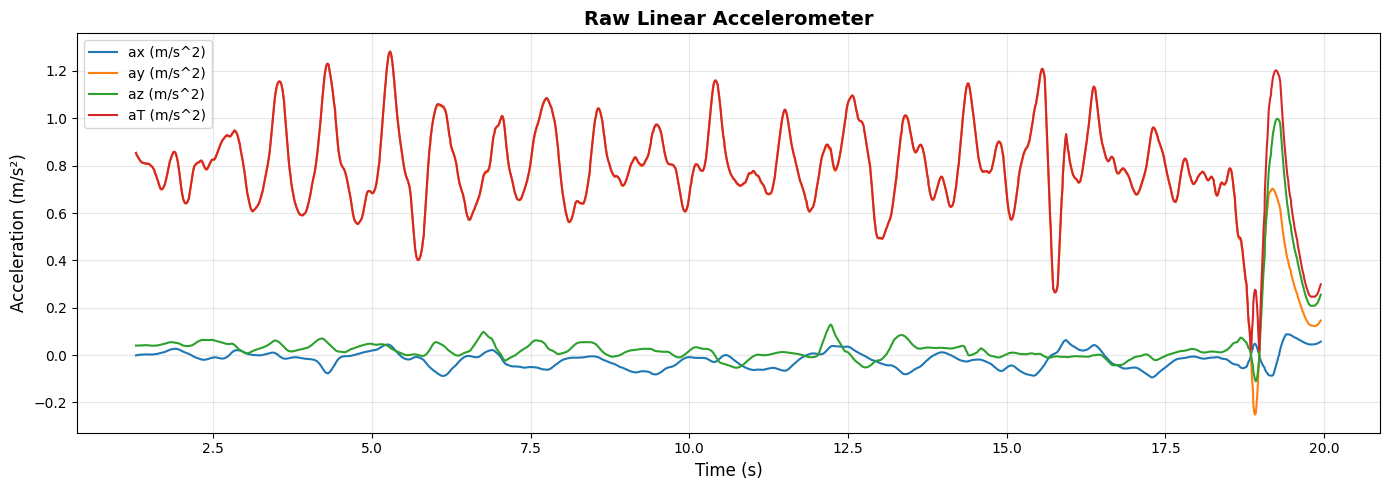

Accelerometer plot created with 4 signals
No gyroscope columns found!

Processing: Raw Gyroscope
Original columns: ['time', 'wx (rad/s)', 'wy (rad/s)', 'wz (rad/s)']
Time column: 'time' - Range: 0.00 to 23.10s

Accelerometer columns found: []
Gyroscope columns found: ['wx (rad/s)', 'wy (rad/s)', 'wz (rad/s)']
No accelerometer columns found!


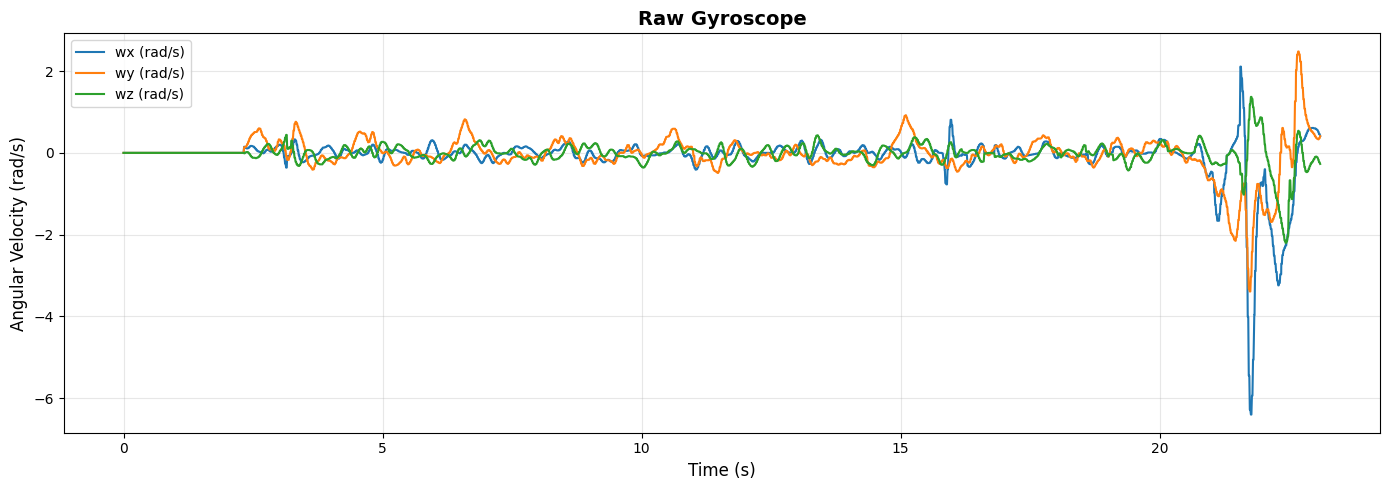

Gyroscope plot created with 3 signals

Processing: Combined Data
Original columns: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2', 'linear_time', 'wx_rad/s', 'wy_rad/s', 'wz_rad/s', 'activity']
Time column: 'linear_time' - Range: 0.01 to 24.27s

Accelerometer columns found: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2']
Gyroscope columns found: ['wx_rad/s', 'wy_rad/s', 'wz_rad/s']


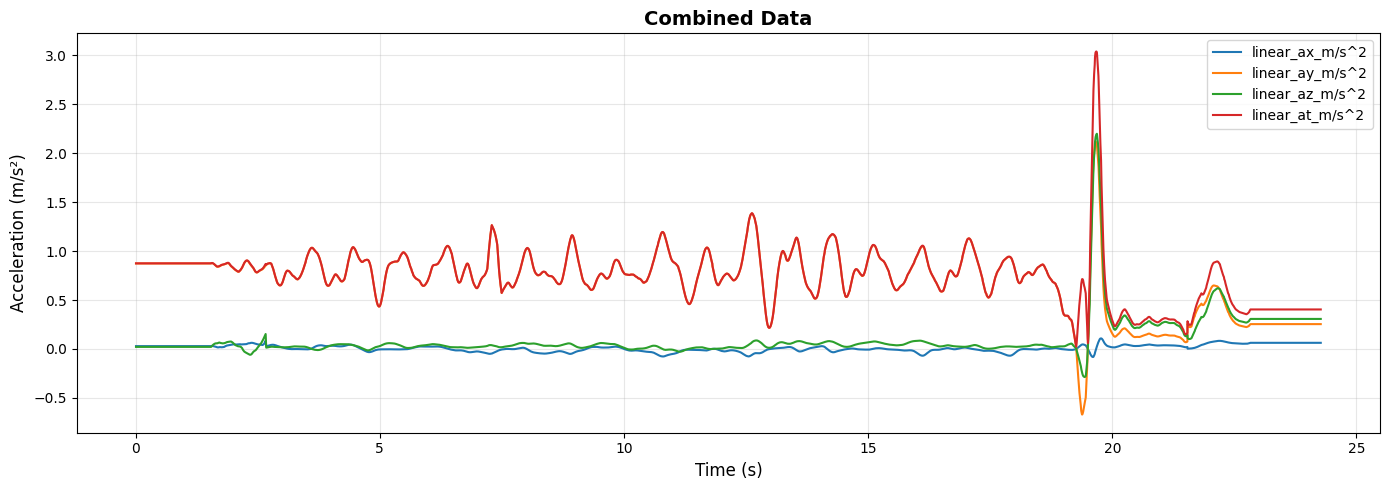

Accelerometer plot created with 4 signals


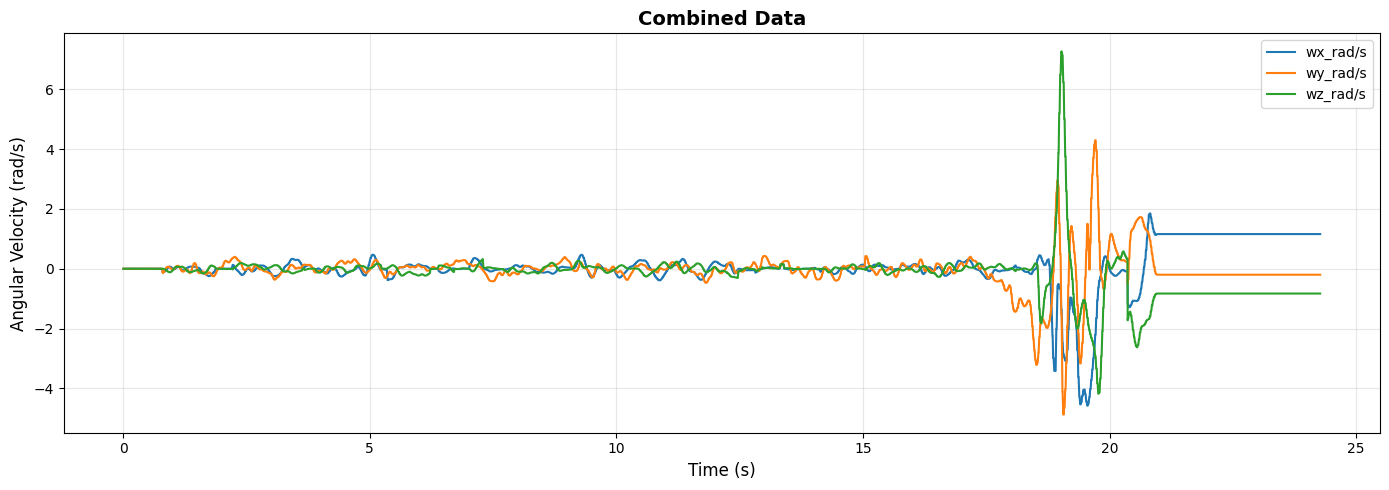

Gyroscope plot created with 3 signals

Processing: Harmonized Combined Data
Original columns: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2', 'linear_time', 'wx_rad/s', 'wy_rad/s', 'wz_rad/s', 'activity']
Time column: 'linear_time' - Range: 0.01 to 24.27s

Accelerometer columns found: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2']
Gyroscope columns found: ['wx_rad/s', 'wy_rad/s', 'wz_rad/s']


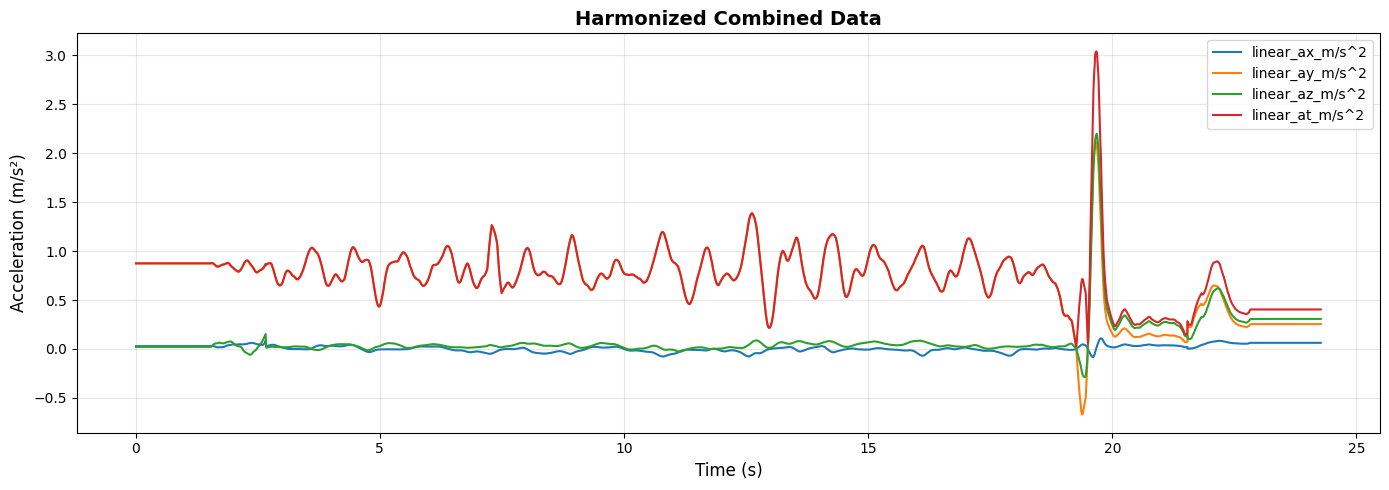

Accelerometer plot created with 4 signals


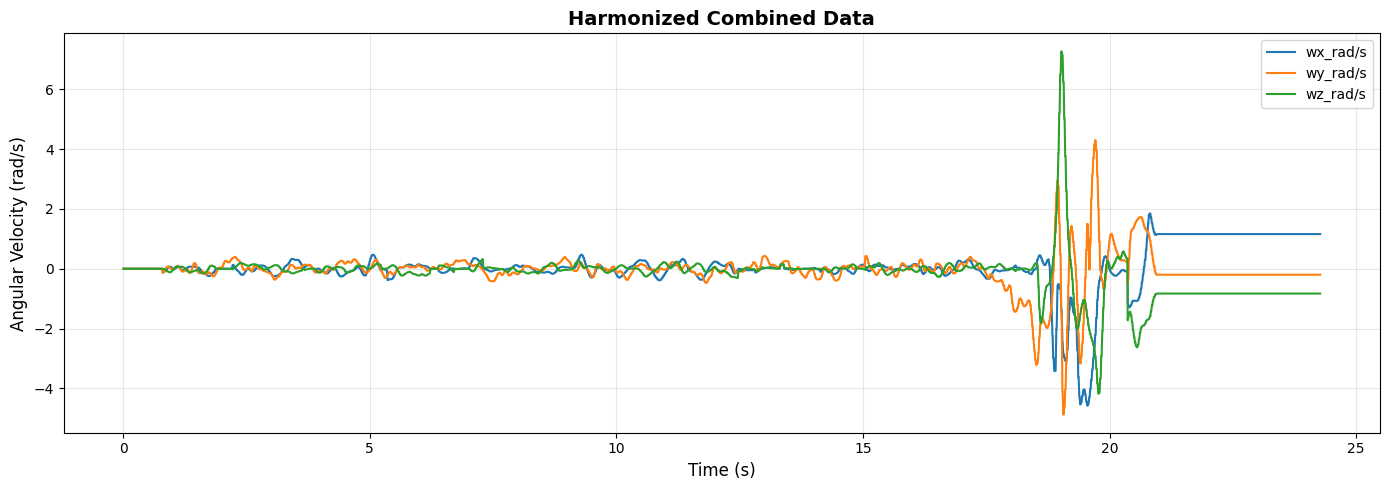

Gyroscope plot created with 3 signals


In [52]:



plot_motion_data('/content/walking/linear walking 1.csv', 'Raw Linear Accelerometer')

plot_motion_data('/content/walking/walking 1.csv', 'Raw Gyroscope')

plot_motion_data('/content/walking_combined.csv', 'Combined Data')

plot_motion_data('/content/walking_combined_harmonized.csv', 'Harmonized Combined Data')




Processing: Raw Linear Accelerometer
Original columns: ['time', 'ax (m/s^2)', 'ay (m/s^2)', 'az (m/s^2)', 'aT (m/s^2)']
Time column: 'time' - Range: 0.00 to 5.94s

Accelerometer columns found: ['ax (m/s^2)', 'ay (m/s^2)', 'az (m/s^2)', 'aT (m/s^2)']
Gyroscope columns found: []


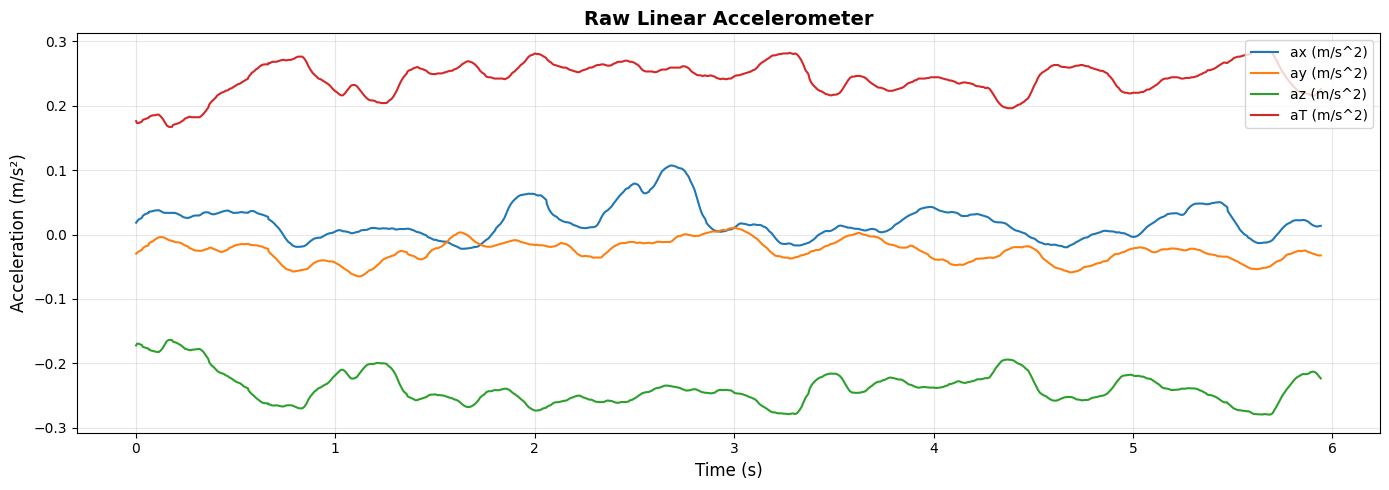

Accelerometer plot created with 4 signals
No gyroscope columns found!

Processing: Raw Gyroscope
Original columns: ['time', 'wx (rad/s)', 'wy (rad/s)', 'wz (rad/s)']
Time column: 'time' - Range: 0.00 to 12.16s

Accelerometer columns found: []
Gyroscope columns found: ['wx (rad/s)', 'wy (rad/s)', 'wz (rad/s)']
No accelerometer columns found!


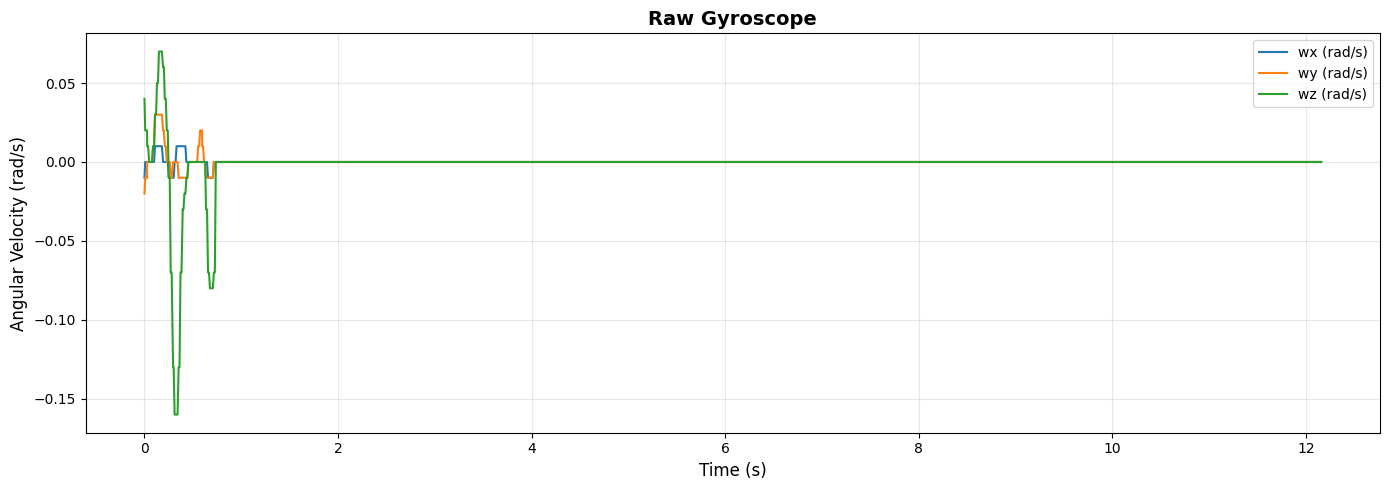

Gyroscope plot created with 3 signals

Processing: Combined Data
Original columns: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2', 'linear_time', 'wx_rad/s', 'wy_rad/s', 'wz_rad/s', 'activity']
Time column: 'linear_time' - Range: 0.00 to 12.48s

Accelerometer columns found: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2']
Gyroscope columns found: ['wx_rad/s', 'wy_rad/s', 'wz_rad/s']


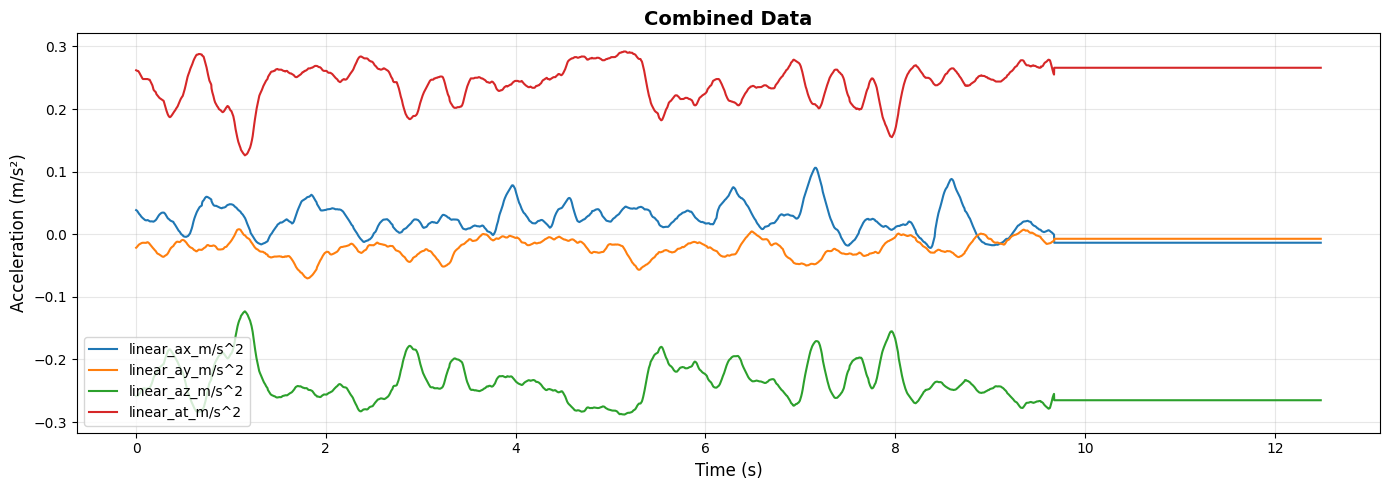

Accelerometer plot created with 4 signals


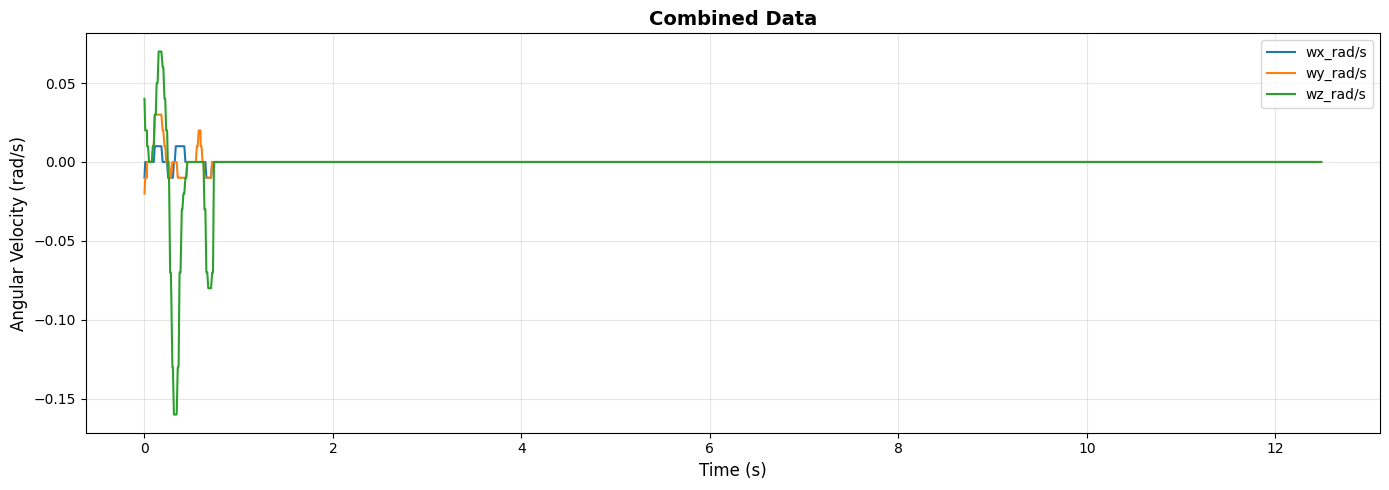

Gyroscope plot created with 3 signals

Processing: Harmonized Combined Data
Original columns: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2', 'linear_time', 'wx_rad/s', 'wy_rad/s', 'wz_rad/s', 'activity']
Time column: 'linear_time' - Range: 0.00 to 12.48s

Accelerometer columns found: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2']
Gyroscope columns found: ['wx_rad/s', 'wy_rad/s', 'wz_rad/s']


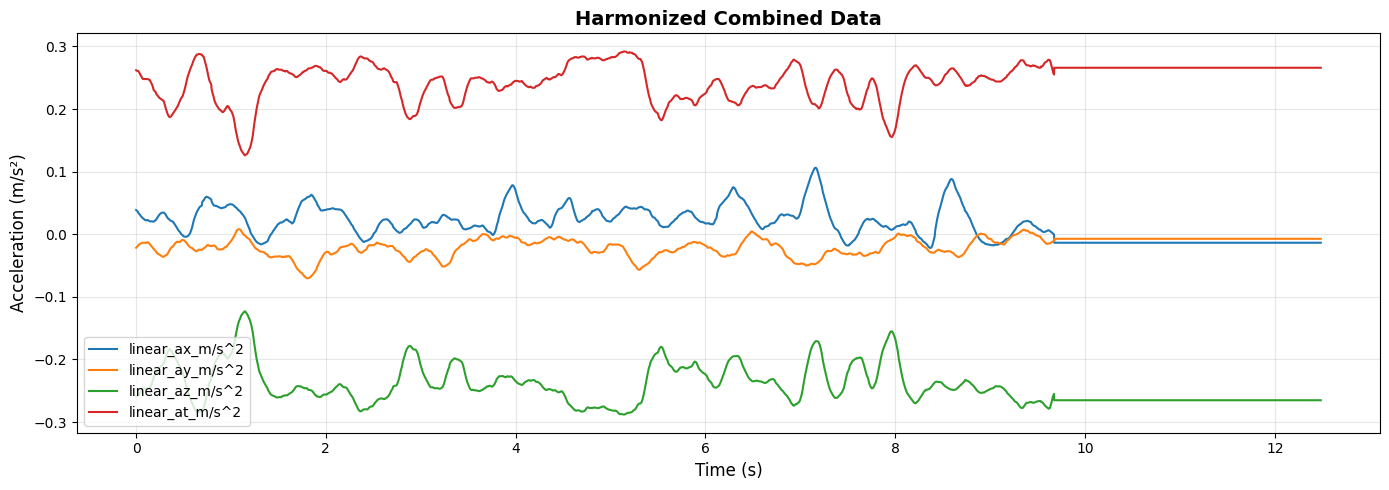

Accelerometer plot created with 4 signals


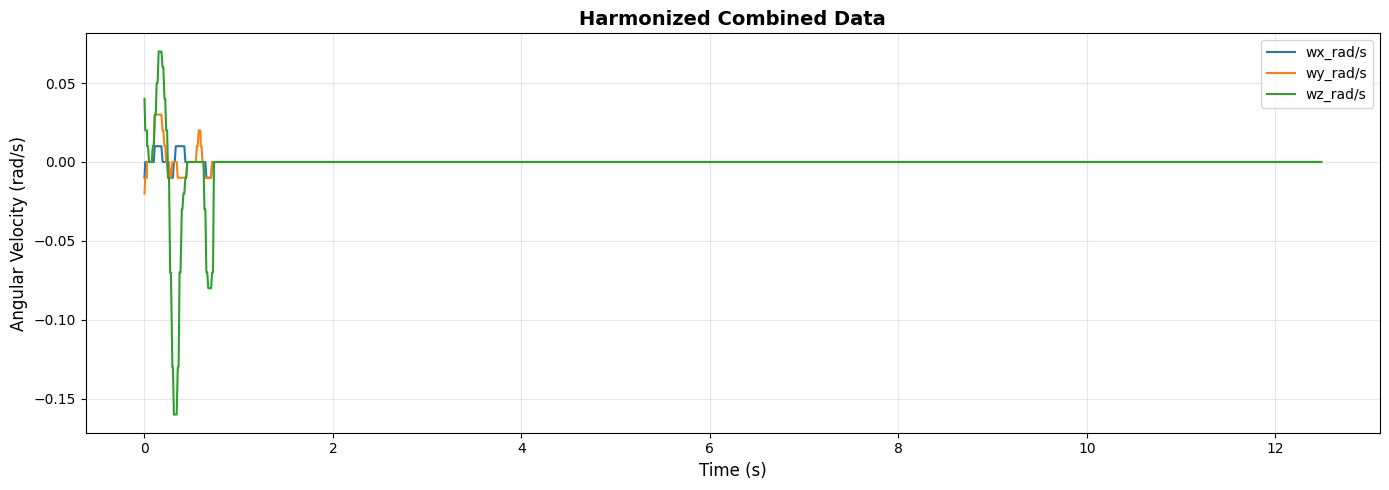

Gyroscope plot created with 3 signals


In [53]:
plot_motion_data('/content/still/linear still 1.csv', 'Raw Linear Accelerometer')

plot_motion_data('/content/still/still 1.csv', 'Raw Gyroscope')

plot_motion_data('/content/still_combined.csv', 'Combined Data')

plot_motion_data('/content/still_combined_harmonized.csv', 'Harmonized Combined Data')


Processing: Raw Linear Accelerometer
Original columns: ['time', 'ax (m/s^2)', 'ay (m/s^2)', 'az (m/s^2)', 'aT (m/s^2)']
Time column: 'time' - Range: 0.00 to 15.64s

Accelerometer columns found: ['ax (m/s^2)', 'ay (m/s^2)', 'az (m/s^2)', 'aT (m/s^2)']
Gyroscope columns found: []


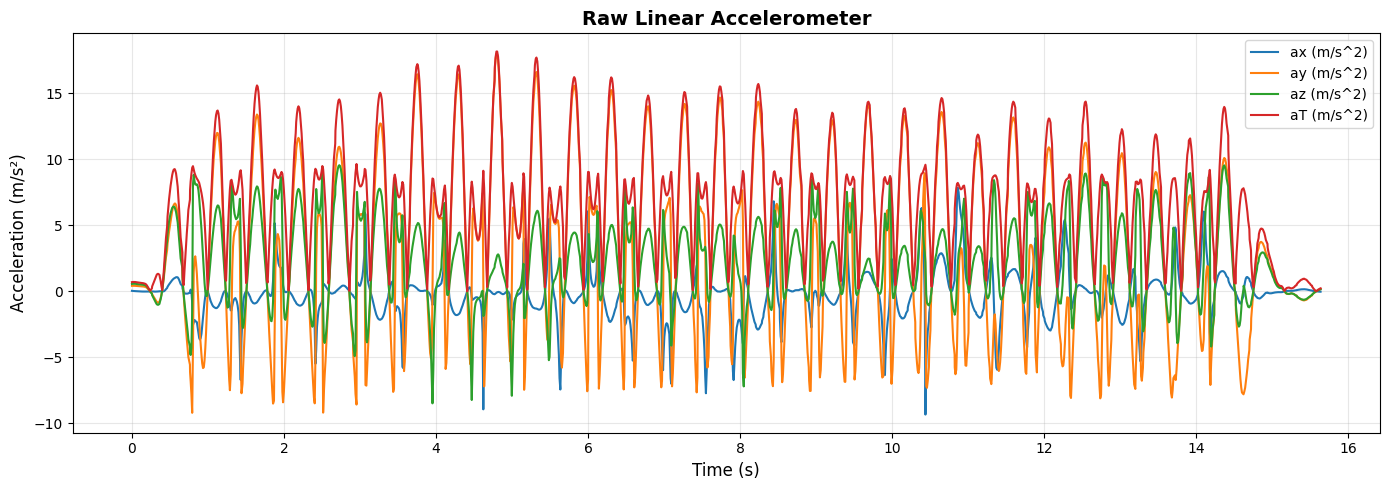

Accelerometer plot created with 4 signals
No gyroscope columns found!

Processing: Raw Gyroscope
Original columns: ['time', 'wx (rad/s)', 'wy (rad/s)', 'wz (rad/s)']
Time column: 'time' - Range: 0.01 to 18.15s

Accelerometer columns found: []
Gyroscope columns found: ['wx (rad/s)', 'wy (rad/s)', 'wz (rad/s)']
No accelerometer columns found!


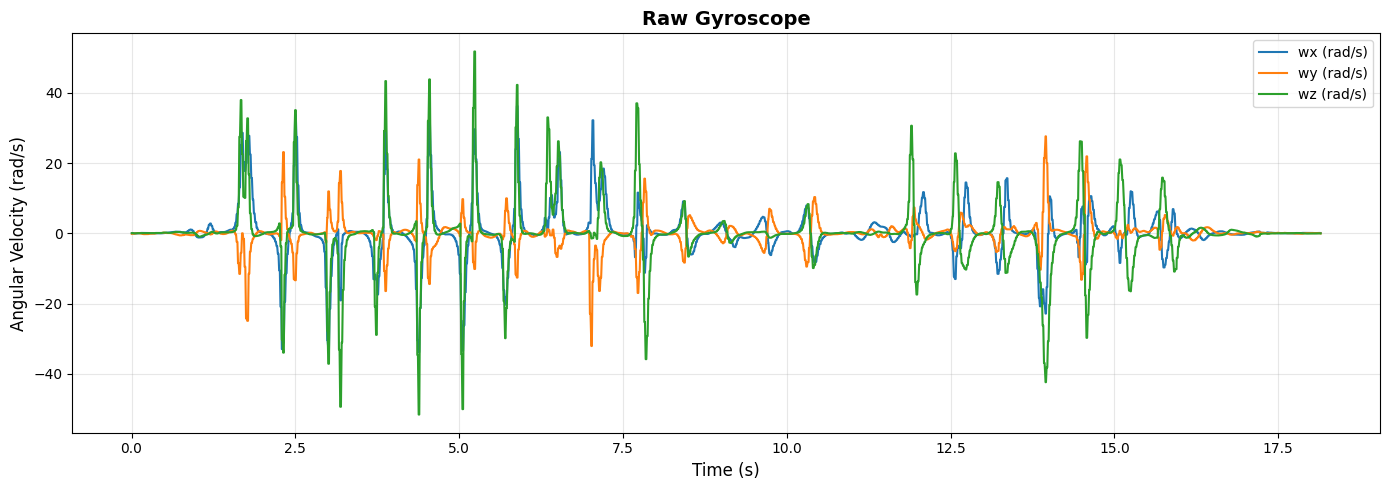

Gyroscope plot created with 3 signals

Processing: Combined Data
Original columns: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2', 'linear_time', 'wx_rad/s', 'wy_rad/s', 'wz_rad/s', 'activity']
Time column: 'linear_time' - Range: 0.00 to 18.60s

Accelerometer columns found: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2']
Gyroscope columns found: ['wx_rad/s', 'wy_rad/s', 'wz_rad/s']


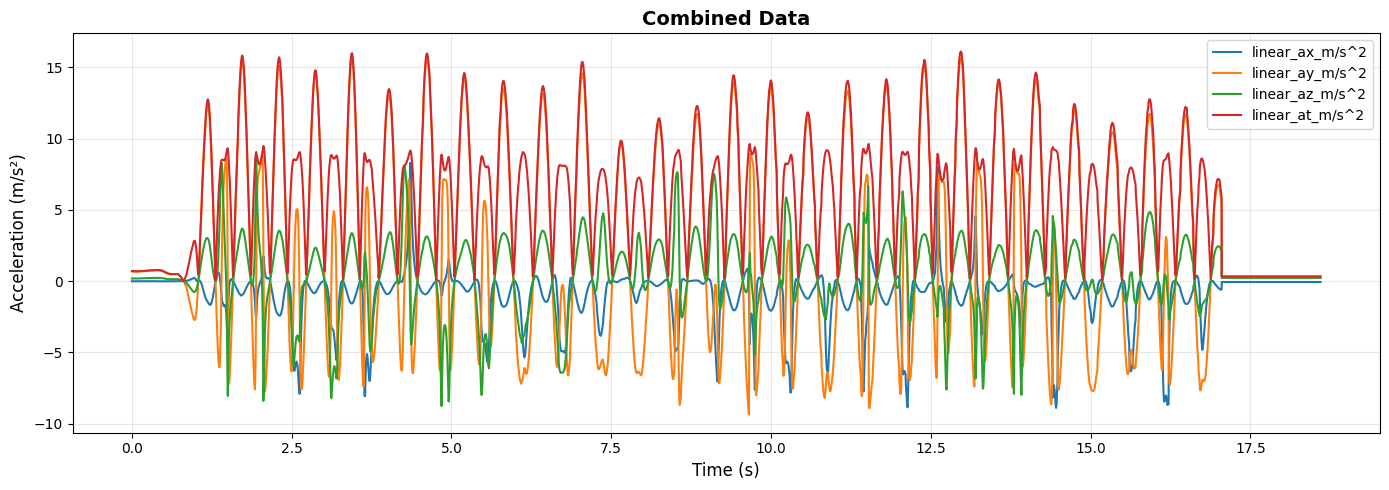

Accelerometer plot created with 4 signals


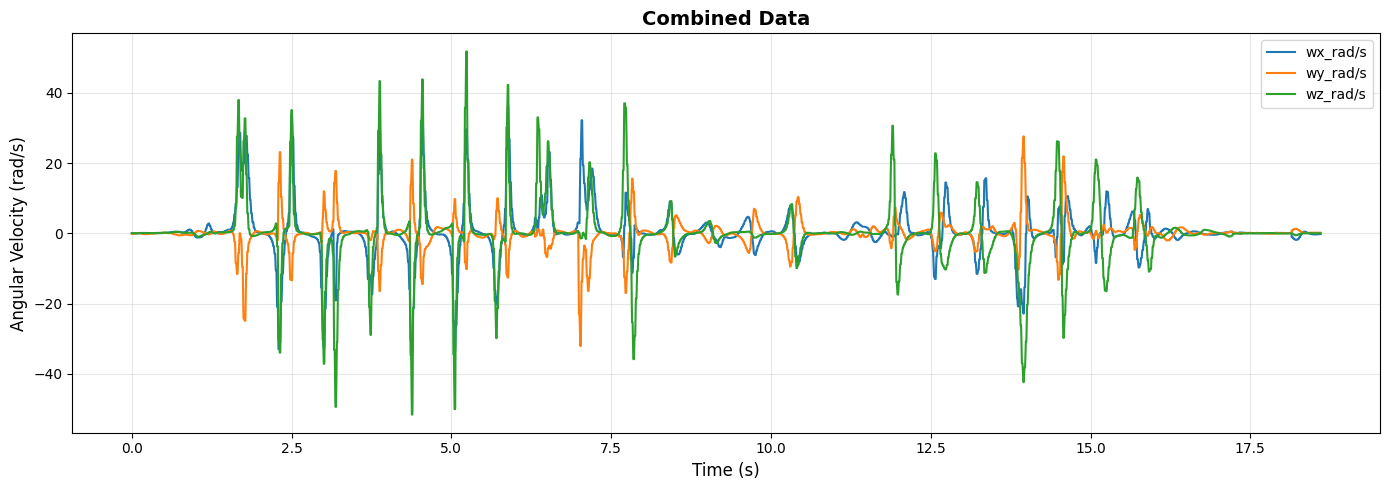

Gyroscope plot created with 3 signals

Processing: Harmonized Combined Data
Original columns: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2', 'linear_time', 'wx_rad/s', 'wy_rad/s', 'wz_rad/s', 'activity']
Time column: 'linear_time' - Range: 0.00 to 18.60s

Accelerometer columns found: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2']
Gyroscope columns found: ['wx_rad/s', 'wy_rad/s', 'wz_rad/s']


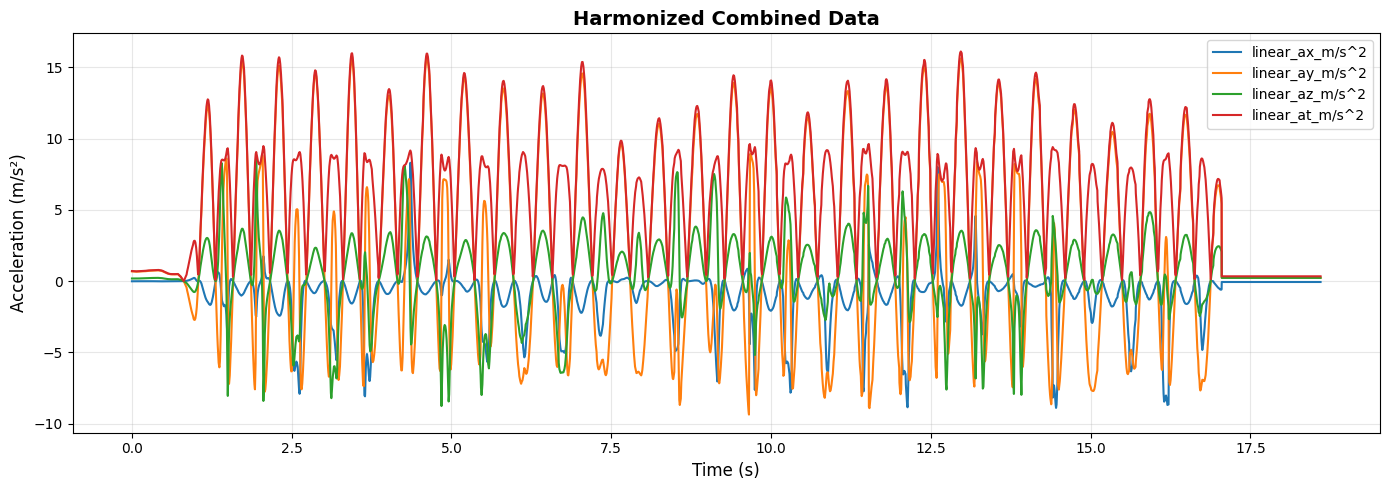

Accelerometer plot created with 4 signals


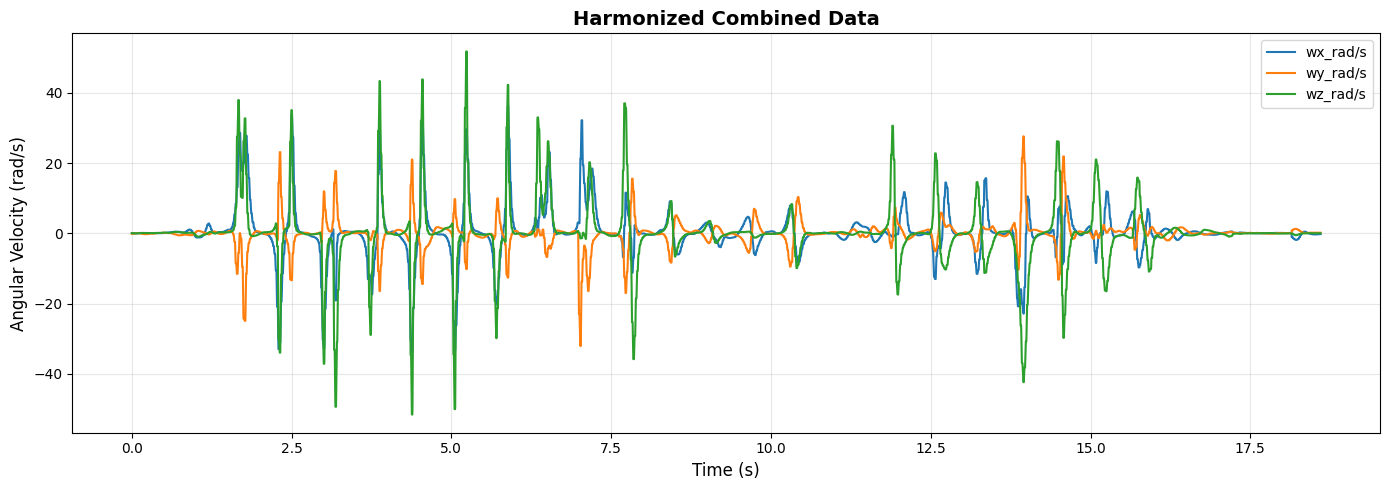

Gyroscope plot created with 3 signals


In [55]:

plot_motion_data('/content/jumping/linear jumping 1.csv', 'Raw Linear Accelerometer')

plot_motion_data('/content/jumping/jumping 1.csv', 'Raw Gyroscope')

plot_motion_data('/content/jumping_combined.csv', 'Combined Data')

plot_motion_data('/content/jumping_combined_harmonized.csv', 'Harmonized Combined Data')


Processing: Raw Linear Accelerometer
Original columns: ['time', 'ax (m/s^2)', 'ay (m/s^2)', 'az (m/s^2)', 'aT (m/s^2)']
Time column: 'time' - Range: 0.00 to 5.13s

Accelerometer columns found: ['ax (m/s^2)', 'ay (m/s^2)', 'az (m/s^2)', 'aT (m/s^2)']
Gyroscope columns found: []


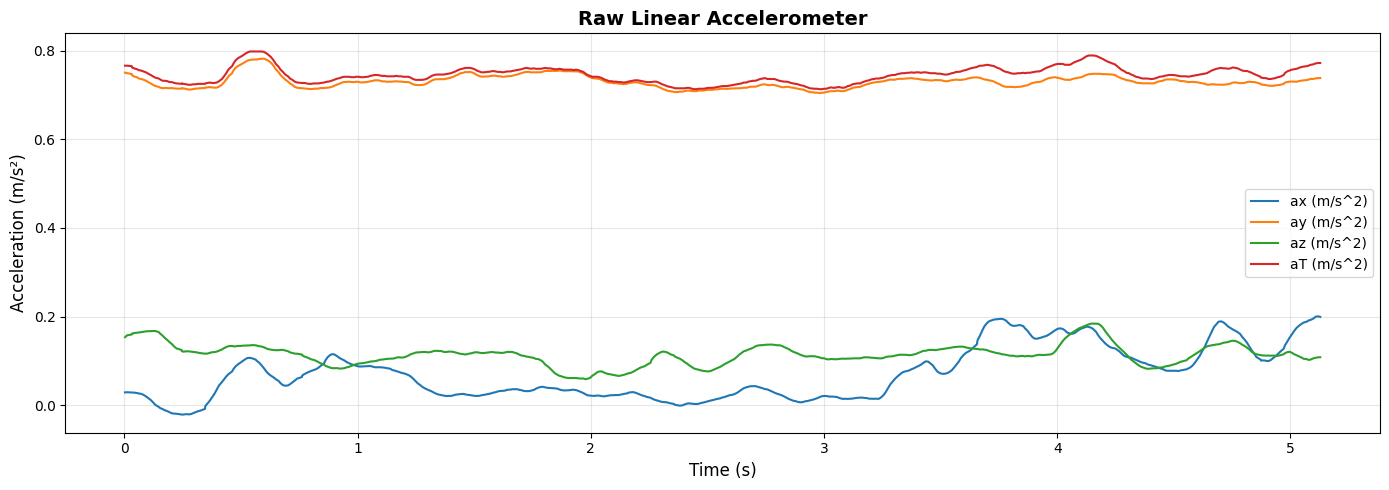

Accelerometer plot created with 4 signals
No gyroscope columns found!

Processing: Raw Gyroscope
Original columns: ['time', 'wx (rad/s)', 'wy (rad/s)', 'wz (rad/s)']
Time column: 'time' - Range: 0.00 to 7.00s

Accelerometer columns found: []
Gyroscope columns found: ['wx (rad/s)', 'wy (rad/s)', 'wz (rad/s)']
No accelerometer columns found!


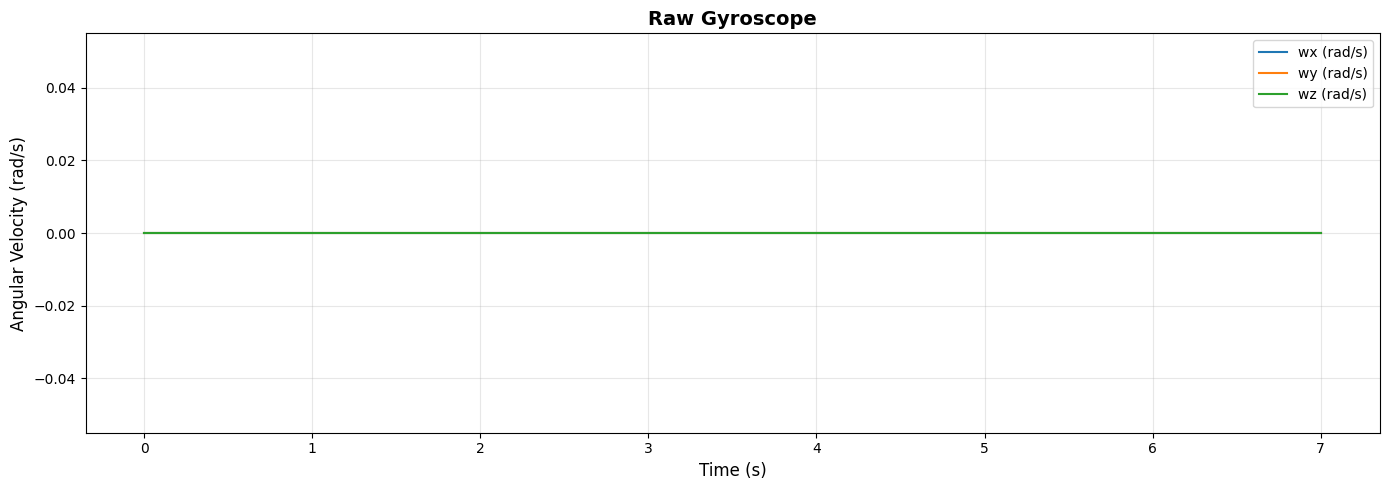

Gyroscope plot created with 3 signals

Processing: Combined Data
Original columns: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2', 'linear_time', 'wx_rad/s', 'wy_rad/s', 'wz_rad/s', 'activity']
Time column: 'linear_time' - Range: 0.00 to 17.82s

Accelerometer columns found: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2']
Gyroscope columns found: ['wx_rad/s', 'wy_rad/s', 'wz_rad/s']


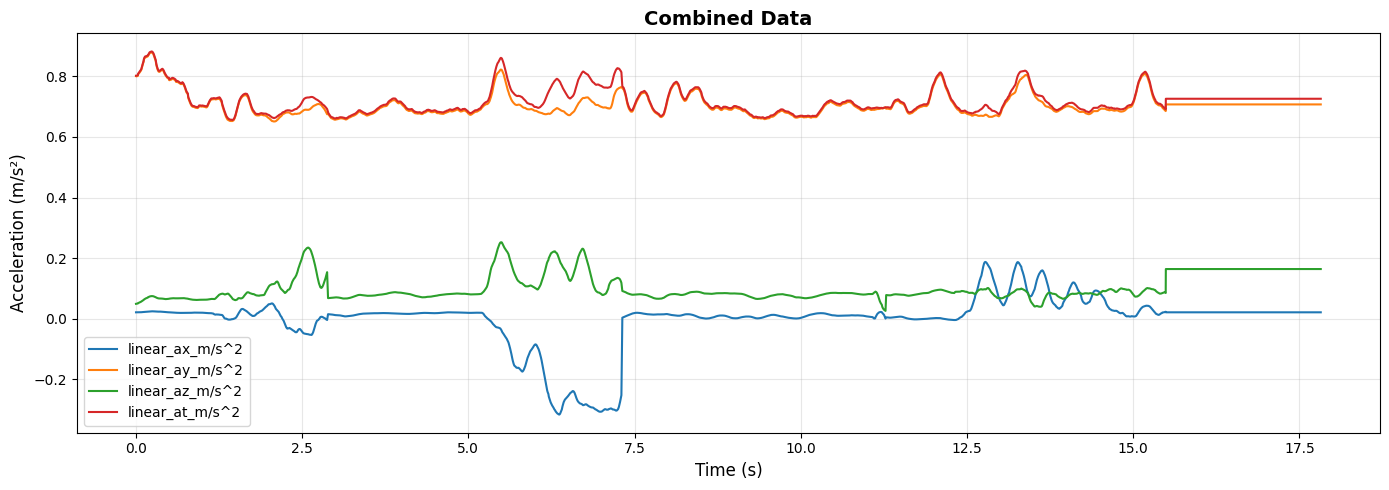

Accelerometer plot created with 4 signals


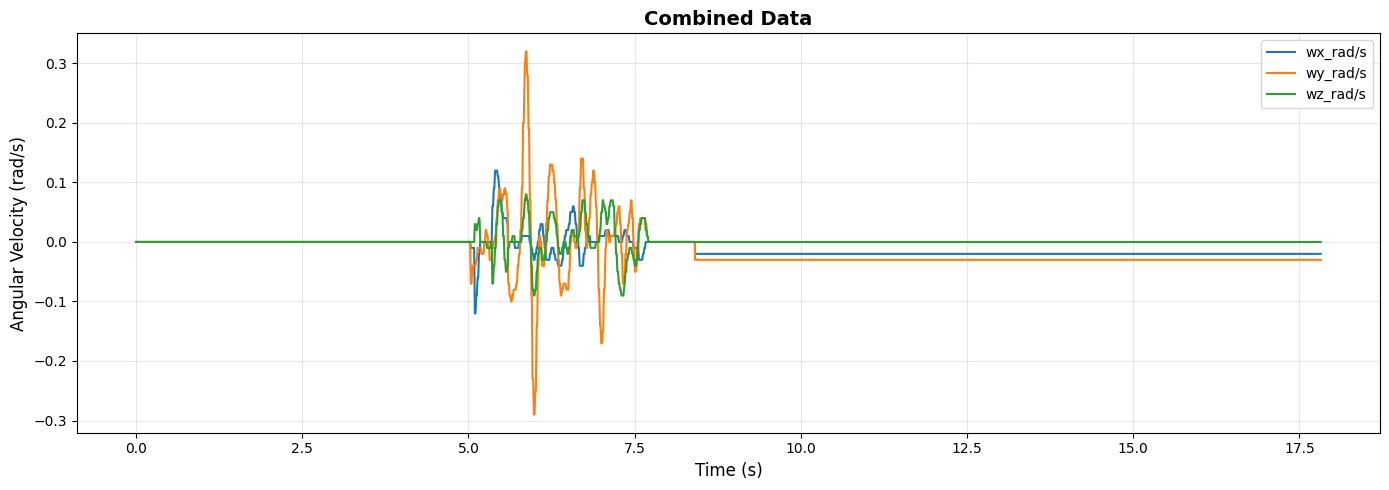

Gyroscope plot created with 3 signals

Processing: Harmonized Combined Data
Original columns: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2', 'linear_time', 'wx_rad/s', 'wy_rad/s', 'wz_rad/s', 'activity']
Time column: 'linear_time' - Range: 0.00 to 17.82s

Accelerometer columns found: ['linear_ax_m/s^2', 'linear_ay_m/s^2', 'linear_az_m/s^2', 'linear_at_m/s^2']
Gyroscope columns found: ['wx_rad/s', 'wy_rad/s', 'wz_rad/s']


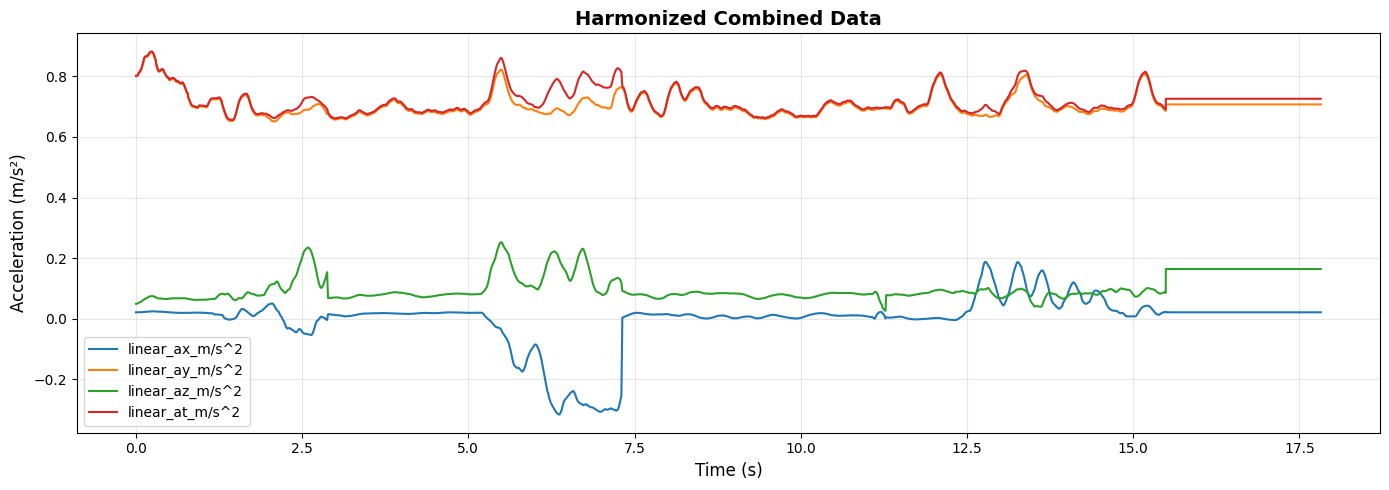

Accelerometer plot created with 4 signals


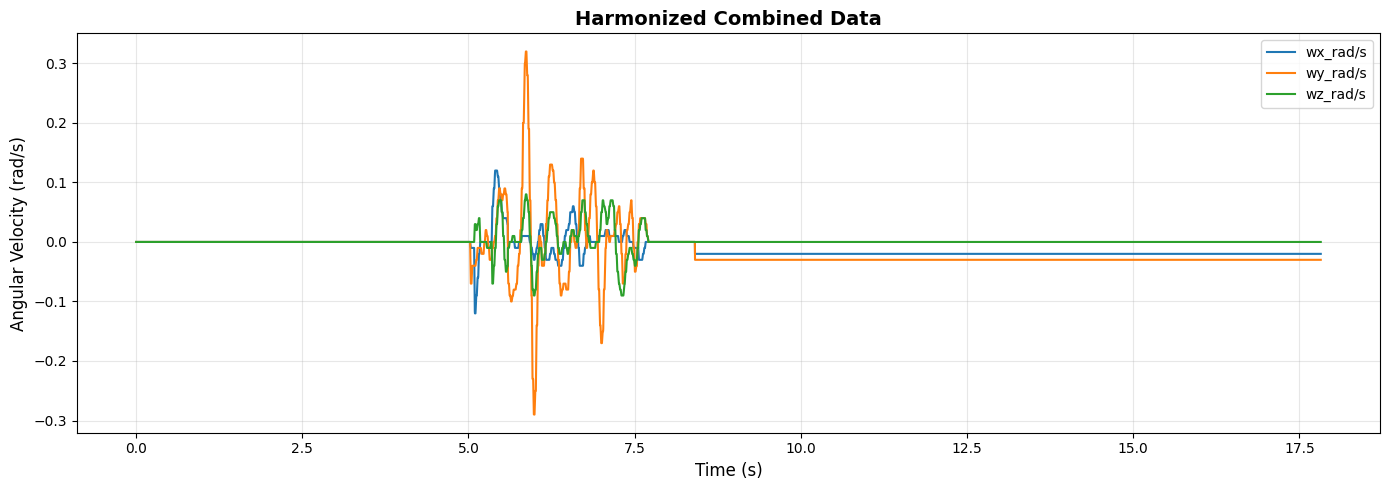

Gyroscope plot created with 3 signals


In [54]:


plot_motion_data('/content/standing/linear standing 1.csv', 'Raw Linear Accelerometer')

plot_motion_data('/content/standing/standing 1.csv', 'Raw Gyroscope')

plot_motion_data('/content/standing_combined.csv', 'Combined Data')

plot_motion_data('/content/standing_combined_harmonized.csv', 'Harmonized Combined Data')



In [56]:

def load_activity_sequences(base_path="/content", activities=["standing", "walking", "jumping", "still"]):
    sequences = {}

    print(f"{'='*60}")
    print("Loading Activity Sequences")
    print(f"{'='*60}")

    for activity in activities:
        file_path = os.path.join(base_path, f"{activity}_combined_harmonized.csv")

        if os.path.exists(file_path):
            df = pd.read_csv(file_path)

            if 'activity' not in df.columns:
                df['activity'] = activity

            sequences[activity] = df
            print(f"✓ {activity:10s}: {len(df):6d} samples")
        else:
            print(f"✗ {activity:10s}: File not found")

    if not sequences:
        raise FileNotFoundError("No activity files found!")

    print(f"{'='*60}\n")
    return sequences

In [60]:
class ActivityFeatureExtractor:

    def __init__(self, window_size=2.0, overlap=0.5, sampling_rate=500):
        self.window_size = window_size
        self.overlap = overlap
        self.sampling_rate = sampling_rate

    def create_windows_from_sequence(self, df, activity_label, time_col='linear_time'):
        window_samples = int(self.window_size * self.sampling_rate)
        step_samples = int(window_samples * (1 - self.overlap))

        print(f"  Sequence length: {len(df)} samples")
        print(f"  Window size: {window_samples} samples ({self.window_size}s)")
        print(f"  Step size: {step_samples} samples")

        if len(df) < window_samples:
            print(f"WARNING: Sequence too short! Need {window_samples} samples, have {len(df)}")
            print(f"Consider reducing window_size or collecting more data")
            return [], []

        windows = []
        labels = []

        for start in range(0, len(df) - window_samples + 1, step_samples):
            end = start + window_samples
            window_df = df.iloc[start:end]
            windows.append(window_df)
            labels.append(activity_label)

        return windows, labels

    def extract_time_features(self, signal):

        signal_safe = signal + 1e-10

        features = {
            'mean': np.mean(signal),
            'std': np.std(signal),
            'var': np.var(signal),
            'min': np.min(signal),
            'max': np.max(signal),
            'range': np.ptp(signal),
            'median': np.median(signal),
            'q25': np.percentile(signal, 25),
            'q75': np.percentile(signal, 75),
            'iqr': np.percentile(signal, 75) - np.percentile(signal, 25),
            'rms': np.sqrt(np.mean(signal ** 2)),
            'energy': np.sum(signal ** 2) / len(signal),
            'zcr': np.sum(np.diff(np.sign(signal)) != 0) / len(signal)
        }

        if np.std(signal) > 1e-6:
            try:
                features['skewness'] = stats.skew(signal)
                features['kurtosis'] = stats.kurtosis(signal)
            except:
                features['skewness'] = 0.0
                features['kurtosis'] = 0.0
        else:
            features['skewness'] = 0.0
            features['kurtosis'] = 0.0

        return features

    def extract_freq_features(self, signal):
        """Frequency-domain features using FFT"""
        n = len(signal)
        yf = fft(signal)
        xf = fftfreq(n, 1/self.sampling_rate)

        pos_mask = xf > 0
        freqs = xf[pos_mask]
        magnitude = np.abs(yf[pos_mask])

        dom_idx = np.argmax(magnitude)

        low_band = (freqs < 2)
        mid_band = (freqs >= 2) & (freqs < 5)
        high_band = (freqs >= 5)

        return {
            'dom_freq': freqs[dom_idx],
            'dom_mag': magnitude[dom_idx],
            'spectral_energy': np.sum(magnitude ** 2),
            'spectral_entropy': stats.entropy(magnitude + 1e-10),
            'low_energy': np.sum(magnitude[low_band] ** 2),
            'mid_energy': np.sum(magnitude[mid_band] ** 2),
            'high_energy': np.sum(magnitude[high_band] ** 2),
            'spectral_centroid': np.sum(freqs * magnitude) / (np.sum(magnitude) + 1e-10)
        }

    def extract_window_features(self, window_df):
        """Extract all features from a window"""
        features = {}

        accel_cols = {
            'ax': 'linear_ax_m/s^2',
            'ay': 'linear_ay_m/s^2',
            'az': 'linear_az_m/s^2'
        }

        gyro_cols = {
            'wx': 'wx_rad/s',
            'wy': 'wy_rad/s',
            'wz': 'wz_rad/s'
        }

        for axis_name, col_name in accel_cols.items():
            if col_name in window_df.columns:
                signal = window_df[col_name].values

                time_feat = self.extract_time_features(signal)
                for k, v in time_feat.items():
                    features[f'accel_{axis_name}_{k}'] = v

                freq_feat = self.extract_freq_features(signal)
                for k, v in freq_feat.items():
                    features[f'accel_{axis_name}_{k}'] = v

        for axis_name, col_name in gyro_cols.items():
            if col_name in window_df.columns:
                signal = window_df[col_name].values

                time_feat = self.extract_time_features(signal)
                for k, v in time_feat.items():
                    features[f'gyro_{axis_name}_{k}'] = v

                freq_feat = self.extract_freq_features(signal)
                for k, v in freq_feat.items():
                    features[f'gyro_{axis_name}_{k}'] = v

        ax = window_df['linear_ax_m/s^2'].values
        ay = window_df['linear_ay_m/s^2'].values
        az = window_df['linear_az_m/s^2'].values

        features['accel_sma'] = (np.sum(np.abs(ax)) + np.sum(np.abs(ay)) + np.sum(np.abs(az))) / len(ax)

        def safe_corr(a, b):
            if np.std(a) < 1e-6 or np.std(b) < 1e-6:
                return 0.0
            try:
                corr = np.corrcoef(a, b)[0, 1]
                return 0.0 if np.isnan(corr) or np.isinf(corr) else corr
            except:
                return 0.0

        features['accel_corr_xy'] = safe_corr(ax, ay)
        features['accel_corr_xz'] = safe_corr(ax, az)
        features['accel_corr_yz'] = safe_corr(ay, az)

        a_mag = np.sqrt(ax**2 + ay**2 + az**2)
        features['accel_mag_mean'] = np.mean(a_mag)
        features['accel_mag_std'] = np.std(a_mag)
        features['accel_mag_max'] = np.max(a_mag)
        features['accel_mag_min'] = np.min(a_mag)
        features['accel_mag_range'] = np.ptp(a_mag)

        features['accel_mag_cv'] = features['accel_mag_std'] / (features['accel_mag_mean'] + 1e-10)
        features['accel_total_variation'] = np.sum(np.abs(np.diff(a_mag)))
        features['accel_mean_abs_diff'] = np.mean(np.abs(np.diff(a_mag)))

        wx = window_df['wx_rad/s'].values
        wy = window_df['wy_rad/s'].values
        wz = window_df['wz_rad/s'].values

        w_mag = np.sqrt(wx**2 + wy**2 + wz**2)
        features['gyro_mag_mean'] = np.mean(w_mag)
        features['gyro_mag_std'] = np.std(w_mag)
        features['gyro_mag_max'] = np.max(w_mag)
        features['gyro_mag_min'] = np.min(w_mag)
        features['gyro_mag_range'] = np.ptp(w_mag)

        features['gyro_mag_cv'] = features['gyro_mag_std'] / (features['gyro_mag_mean'] + 1e-10)
        features['gyro_total_variation'] = np.sum(np.abs(np.diff(w_mag)))
        features['gyro_mean_abs_diff'] = np.mean(np.abs(np.diff(w_mag)))

        features['gyro_corr_xy'] = safe_corr(wx, wy)
        features['gyro_corr_xz'] = safe_corr(wx, wz)
        features['gyro_corr_yz'] = safe_corr(wy, wz)

        features['accel_gyro_ratio'] = features['accel_mag_mean'] / (features['gyro_mag_mean'] + 1e-10)
        features['movement_intensity'] = features['accel_mag_std'] + features['gyro_mag_std']

        return features

    def process_sequences(self, sequences):
        """Process all activity sequences separately"""
        print(f"\n{'='*60}")
        print("Extracting Features from Activity Sequences")
        print(f"{'='*60}")

        activity_features = {}

        for activity, df in sequences.items():
            print(f"\n{activity}:")
            windows, labels = self.create_windows_from_sequence(df, activity)
            print(f"  Created {len(windows)} windows")

            feature_list = []
            for window in windows:
                features = self.extract_window_features(window)
                feature_list.append(features)

            features_df = pd.DataFrame(feature_list)
            features_df['activity'] = activity
            activity_features[activity] = features_df

            print(f"  Extracted {features_df.shape[1] - 1} features per window")

        print(f"\n{'='*60}\n")
        return activity_features

In [63]:
class ActivityHMM:

    def __init__(self, n_iter=100):
        self.model = None
        self.scaler = StandardScaler()
        self.state_names = None
        self.state_to_idx = None
        self.idx_to_state = None
        self.n_iter = n_iter
        self.is_fitted = False  # Track if scaler is fitted

    def prepare_sequences(self, activity_features, fit_scaler=True):
        """
        Prepare sequences for training/testing.

        Args:
            activity_features: Dictionary of activity dataframes
            fit_scaler: If True, fit the scaler. If False, only transform.
        """
        all_X = []
        all_y = []
        lengths = []

        # Only initialize mappings once (during training)
        if self.state_names is None:
            self.state_names = sorted(activity_features.keys())
            self.state_to_idx = {state: idx for idx, state in enumerate(self.state_names)}
            self.idx_to_state = {idx: state for state, idx in self.state_to_idx.items()}

            print(f"\nActivity State Mapping:")
            for state, idx in self.state_to_idx.items():
                print(f"  {state:10s} → State {idx}")

        print(f"\nCreating sequences...")

        for activity in self.state_names:
            if activity not in activity_features:
                continue

            features_df = activity_features[activity]
            X = features_df.drop(columns=['activity']).values
            y = features_df['activity'].map(self.state_to_idx).values

            if len(X) > 0:
                all_X.append(X)
                all_y.append(y)
                lengths.append(len(X))
                print(f"  {activity:10s}: {len(X)} windows")

        X_combined = np.vstack(all_X)
        y_combined = np.hstack(all_y)

        # Handle invalid values
        print(f"\nChecking for invalid values...")
        n_nan = np.isnan(X_combined).sum()
        n_inf = np.isinf(X_combined).sum()

        if n_nan > 0:
            print(f"Found {n_nan} NaN values - replacing with 0")
            X_combined = np.nan_to_num(X_combined, nan=0.0)

        if n_inf > 0:
            print(f"Found {n_inf} Inf values - replacing with large finite values")
            X_combined = np.nan_to_num(X_combined, posinf=1e10, neginf=-1e10)

        if n_nan == 0 and n_inf == 0:
            print(f"No invalid values found")

        # CRITICAL FIX: Only fit scaler on training data
        if fit_scaler:
            print(f"\n✓ Fitting scaler on TRAINING data")
            X_scaled = self.scaler.fit_transform(X_combined)
            self.is_fitted = True
        else:
            if not self.is_fitted:
                raise ValueError("Scaler must be fitted before transforming test data!")
            print(f"\n✓ Transforming TEST data using fitted scaler")
            X_scaled = self.scaler.transform(X_combined)

        print(f"\nDataset Structure:")
        print(f"  Total windows: {len(X_scaled)}")
        print(f"  Features: {X_scaled.shape[1]}")
        print(f"  Sequences: {len(lengths)}")
        print(f"  Sequence lengths: {lengths}")

        return X_scaled, y_combined, lengths

    def split_for_training(self, activity_features, test_size=0.3):
        """Split each activity sequence for train/test"""
        train_features = {}
        test_features = {}

        print(f"\n{'='*60}")
        print(f"Splitting Data (Train: {int((1-test_size)*100)}%, Test: {int(test_size*100)}%)")
        print(f"{'='*60}")

        for activity, features_df in activity_features.items():
            n_samples = len(features_df)
            split_idx = int(n_samples * (1 - test_size))

            train_features[activity] = features_df.iloc[:split_idx]
            test_features[activity] = features_df.iloc[split_idx:]

            print(f"{activity:10s}: Train={len(train_features[activity]):4d}, Test={len(test_features[activity]):4d}")

        print(f"{'='*60}\n")
        return train_features, test_features

    def train(self, train_features):
        """Train single HMM with supervised initialization"""
        # FIT scaler on training data
        X_train, y_train, lengths = self.prepare_sequences(train_features, fit_scaler=True)

        n_states = len(self.state_names)

        print(f"\n{'='*60}")
        print(f"Training Unified HMM (Baum-Welch Algorithm)")
        print(f"{'='*60}")
        print(f"States: {n_states}")
        print(f"Features: {X_train.shape[1]}")
        print(f"Training windows: {len(X_train)}")

        self.model = hmm.GaussianHMM(
            n_components=n_states,
            covariance_type="diag",
            n_iter=self.n_iter,
            random_state=42,
            verbose=False,
            params="stmc",
            init_params=""
        )

        print(f"\nInitializing with supervised learning...")

        # Initialize means and covariances from training data
        means = []
        covars = []
        for state_idx in range(n_states):
            state_mask = (y_train == state_idx)
            state_data = X_train[state_mask]

            if len(state_data) > 0:
                means.append(np.mean(state_data, axis=0))
                covars.append(np.var(state_data, axis=0) + 1e-6)
            else:
                means.append(np.zeros(X_train.shape[1]))
                covars.append(np.ones(X_train.shape[1]))

        self.model.means_ = np.array(means)
        self.model.covars_ = np.array(covars)

        # Initialize transition matrix
        transmat = np.ones((n_states, n_states)) * 0.05
        np.fill_diagonal(transmat, 0.85)
        transmat = transmat / transmat.sum(axis=1, keepdims=True)
        self.model.transmat_ = transmat

        # Initialize start probabilities
        startprob = np.bincount(y_train, minlength=n_states).astype(float)
        startprob = startprob / startprob.sum()
        self.model.startprob_ = startprob

        print(f"  ✓ Initialized means from labeled data")
        print(f"  ✓ Initialized transition matrix (85% self-transition)")
        print(f"  ✓ Initialized start probabilities from data distribution")

        print(f"\nRefining parameters with Baum-Welch...")
        self.model.fit(X_train, lengths=lengths)

        print(f"\n✓ Training Complete!")
        print(f"  Converged: {self.model.monitor_.converged}")
        print(f"  Iterations: {self.model.monitor_.iter}")
        print(f"{'='*60}\n")

        return self

    def evaluate(self, test_features):
        """Evaluate on test sequences"""
        # ONLY transform test data (do NOT fit)
        X_test, y_test, lengths = self.prepare_sequences(test_features, fit_scaler=False)

        print(f"{'='*60}")
        print(f"Model Evaluation (Viterbi Decoding)")
        print(f"{'='*60}")

        predictions = []
        start = 0
        for length in lengths:
            X_seq = X_test[start:start+length]
            _, pred_seq = self.model.decode(X_seq, algorithm='viterbi')
            predictions.extend(pred_seq)
            start += length

        predictions = np.array(predictions)

        accuracy = np.mean(predictions == y_test)
        conf_matrix = confusion_matrix(y_test, predictions)

        print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

        print(f"{'Activity':<12} | {'Samples':>7} | {'Sensitivity':>11} | {'Specificity':>11}")
        print(f"{'-'*60}")

        results_table = []

        for state_idx, state_name in self.idx_to_state.items():
            tp = conf_matrix[state_idx, state_idx]
            fp = conf_matrix[:, state_idx].sum() - tp
            fn = conf_matrix[state_idx, :].sum() - tp
            tn = conf_matrix.sum() - tp - fp - fn

            n_samples = conf_matrix[state_idx, :].sum()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            results_table.append({
                'State (Activity)': state_name,
                'Number of Samples': n_samples,
                'Sensitivity': f"{sensitivity:.4f}",
                'Specificity': f"{specificity:.4f}",
                'Overall Accuracy': f"{accuracy:.4f}"
            })

            print(f"{state_name:<12} | {n_samples:>7} | {sensitivity:>11.4f} | {specificity:>11.4f}")

        print(f"\n{'='*60}")
        print("RESULTS TABLE FOR REPORT")
        print(f"{'='*60}")
        results_df = pd.DataFrame(results_table)
        print(results_df.to_string(index=False))
        print(f"{'='*60}\n")

        return {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'predictions': predictions,
            'y_test': y_test,
            'results_table': results_df
        }

    def plot_transition_matrix(self):
        """Visualize transition probabilities"""
        plt.figure(figsize=(10, 8))

        sns.heatmap(
            self.model.transmat_,
            annot=True,
            fmt='.3f',
            cmap='YlOrRd',
            xticklabels=self.state_names,
            yticklabels=self.state_names,
            cbar_kws={'label': 'Probability'},
            vmin=0,
            vmax=1
        )

        plt.title('State Transition Probability Matrix (A)\nLearned via Baum-Welch',
                  fontsize=14, fontweight='bold')
        plt.xlabel('To State', fontsize=12)
        plt.ylabel('From State', fontsize=12)
        plt.tight_layout()
        plt.show()

        print("\nTransition Analysis:")
        print(f"{'From':<12} → {'To':<12} | Probability")
        print("-" * 45)
        for i, from_state in enumerate(self.state_names):
            most_likely = np.argmax(self.model.transmat_[i])
            prob = self.model.transmat_[i, most_likely]
            print(f"{from_state:<12} → {self.state_names[most_likely]:<12} | {prob:.4f}")

    def plot_initial_probabilities(self):
        """Plot initial state probabilities"""
        plt.figure(figsize=(10, 5))

        colors = plt.cm.viridis(np.linspace(0, 1, len(self.state_names)))
        bars = plt.bar(self.state_names, self.model.startprob_, color=colors, alpha=0.7, edgecolor='black')

        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

        plt.title('Initial State Probabilities (π)', fontsize=14, fontweight='bold')
        plt.xlabel('Activity State', fontsize=12)
        plt.ylabel('Probability', fontsize=12)
        plt.ylim(0, max(self.model.startprob_) * 1.2)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, conf_matrix):
        """Visualize confusion matrix"""
        plt.figure(figsize=(10, 8))

        sns.heatmap(
            conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=self.state_names,
            yticklabels=self.state_names,
            cbar_kws={'label': 'Count'}
        )

        plt.title('Confusion Matrix\nViterbi Algorithm Results', fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Activity', fontsize=12)
        plt.ylabel('True Activity', fontsize=12)
        plt.tight_layout()
        plt.show()

    def plot_activity_sequence(self, predictions, y_true, max_windows=150):
        """Plot predicted vs true sequence"""
        predictions = predictions[:max_windows]
        y_true = y_true[:max_windows]

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

        time = np.arange(len(predictions))

        ax1.plot(time, predictions, 'o-', linewidth=2, markersize=4, color='red', alpha=0.7)
        ax1.set_yticks(range(len(self.state_names)))
        ax1.set_yticklabels(self.state_names)
        ax1.set_ylabel('Activity', fontsize=12)
        ax1.set_title('Predicted (Viterbi)', fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3)

        ax2.plot(time, y_true, 'o-', linewidth=2, markersize=4, color='green', alpha=0.7)
        ax2.set_yticks(range(len(self.state_names)))
        ax2.set_yticklabels(self.state_names)
        ax2.set_xlabel('Time Window', fontsize=12)
        ax2.set_ylabel('Activity', fontsize=12)
        ax2.set_title('Ground Truth', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

  HUMAN ACTIVITY RECOGNITION - SEQUENCE-BASED HMM

[STEP 1/5] Loading activity sequences...
Loading Activity Sequences
✓ standing  :   8910 samples
✓ walking   :  12129 samples
✓ jumping   :   9298 samples
✓ still     :   6241 samples


Analyzing data dimensions...
  Shortest sequence: 6241 samples
  Longest sequence: 12129 samples

Suggested window_size: 1.00 seconds (500 samples)
   This will create ~24 windows per activity

✓ Sufficient data. Using window_size=2.0s

[STEP 2/5] Extracting features (window=2.0s, overlap=50%)...

Extracting Features from Activity Sequences

standing:
  Sequence length: 8910 samples
  Window size: 1000 samples (2.0s)
  Step size: 500 samples
  Created 16 windows
  Extracted 163 features per window

walking:
  Sequence length: 12129 samples
  Window size: 1000 samples (2.0s)
  Step size: 500 samples
  Created 23 windows
  Extracted 163 features per window

jumping:
  Sequence length: 9298 samples
  Window size: 1000 samples (2.0s)
  Step size: 500 sample

  Extracted 163 features per window

still:
  Sequence length: 6241 samples
  Window size: 1000 samples (2.0s)
  Step size: 500 samples
  Created 11 windows
  Extracted 163 features per window



✓ Total windows created: 67

[STEP 3/5] Splitting sequences for training and testing...

Splitting Data (Train: 70%, Test: 30%)
standing  : Train=  11, Test=   5
walking   : Train=  16, Test=   7
jumping   : Train=  11, Test=   6
still     : Train=   7, Test=   4


[STEP 4/5] Training HMM...

Activity State Mapping:
  jumping    → State 0
  standing   → State 1
  still      → State 2
  walking    → State 3

Creating sequences...
  jumping   : 11 windows
  standing  : 11 windows
  still     : 7 windows
  walking   : 16 windows

Checking for invalid values...
No invalid values found

✓ Fitting scaler on TRAINING data

Dataset Structure:
  Total windows: 45
  Features: 163
  Sequences: 4
  Sequence lengths: [11, 11, 7, 16]

Training Unified HMM (Baum-Welch Algorithm)
States: 4
Features: 163
Train

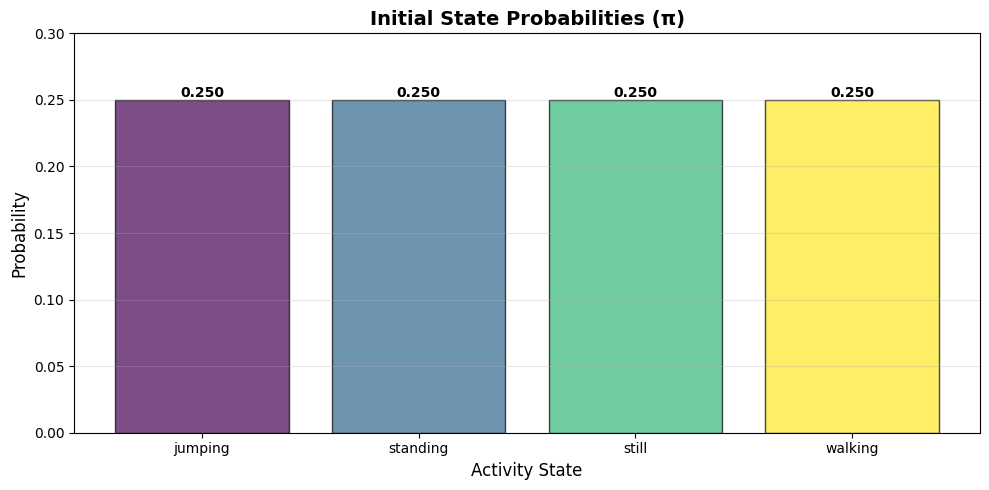

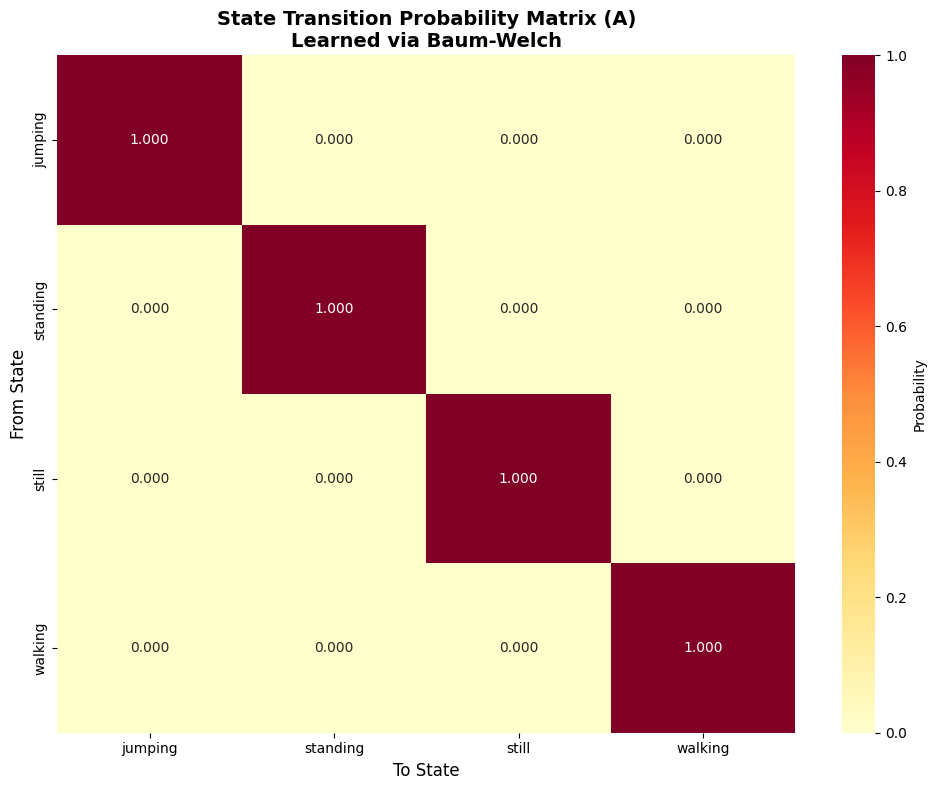


Transition Analysis:
From         → To           | Probability
---------------------------------------------
jumping      → jumping      | 1.0000
standing     → standing     | 1.0000
still        → still        | 1.0000
walking      → walking      | 1.0000


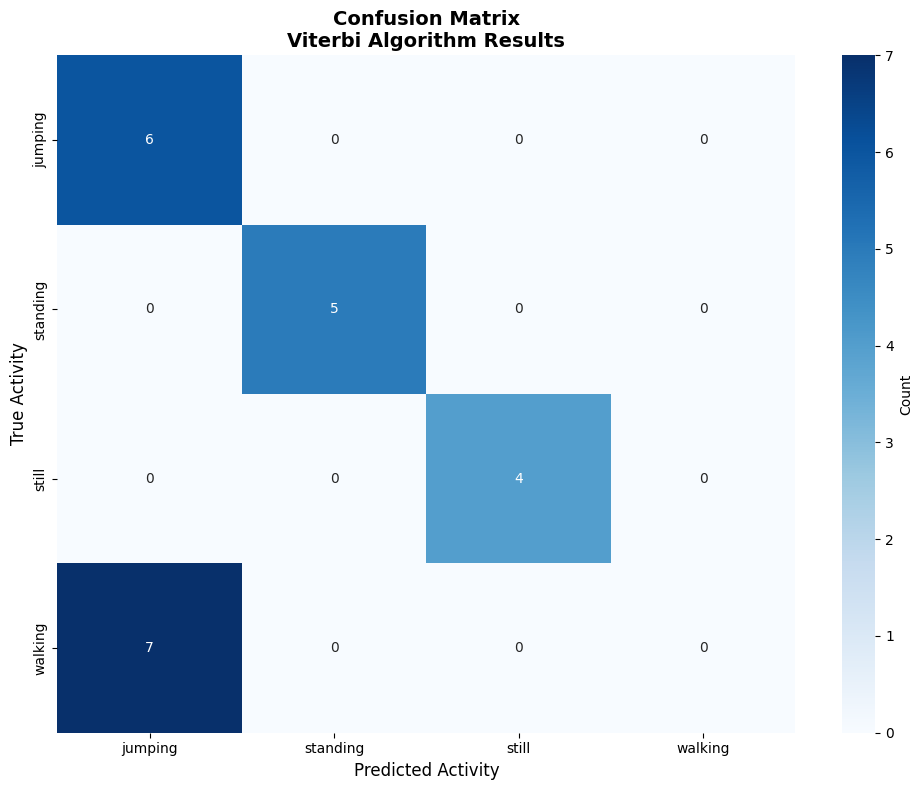

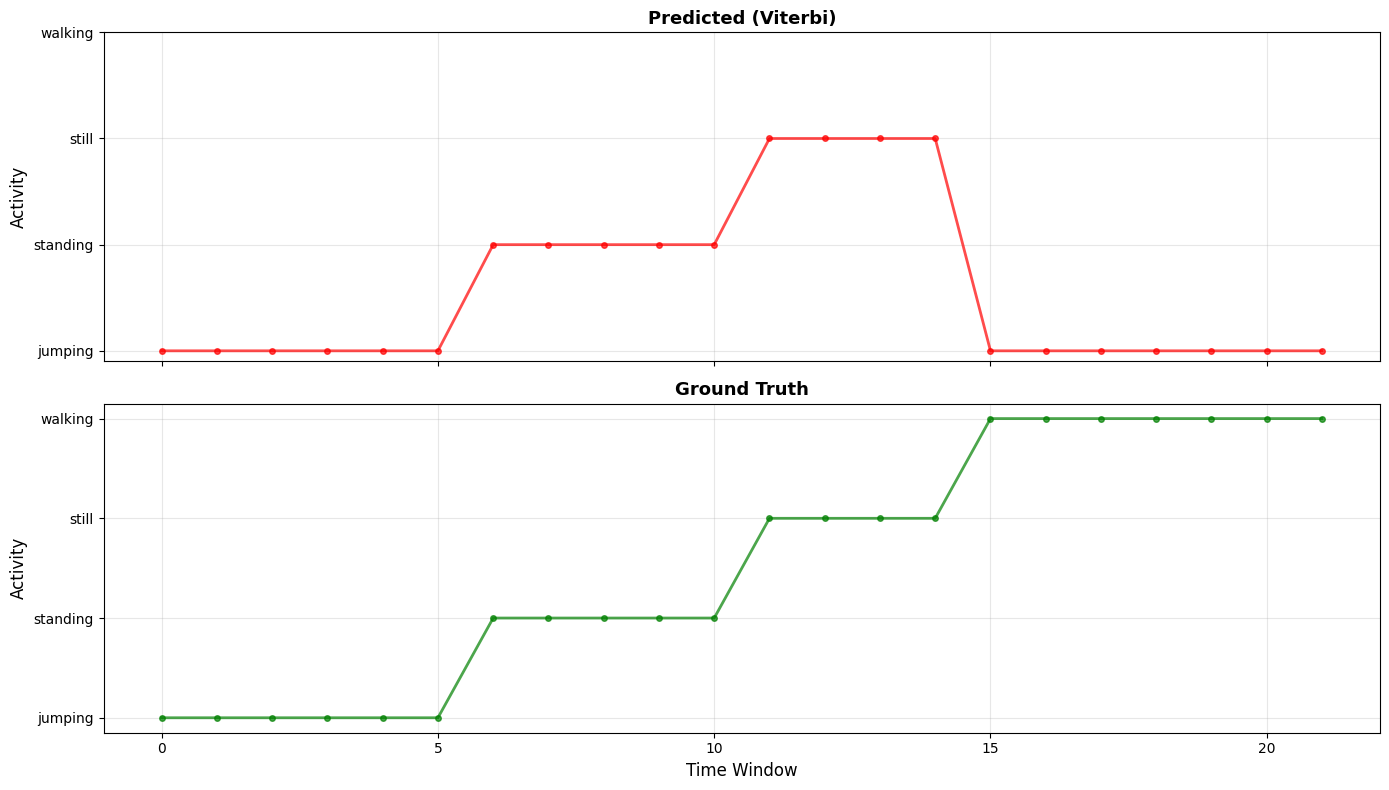


 COMPLETE! All results generated.


In [64]:

if __name__ == "__main__":
    print("="*70)
    print("  HUMAN ACTIVITY RECOGNITION - SEQUENCE-BASED HMM")
    print("="*70)

    print("\n[STEP 1/5] Loading activity sequences...")
    sequences = load_activity_sequences(
        base_path="/content",
        activities=["standing", "walking", "jumping", "still"]
    )

    print("\nAnalyzing data dimensions...")
    min_samples = min(len(df) for df in sequences.values())
    max_samples = max(len(df) for df in sequences.values())
    print(f"  Shortest sequence: {min_samples} samples")
    print(f"  Longest sequence: {max_samples} samples")

    sampling_rate = 500

    suggested_window_samples = min(int(min_samples * 0.1), sampling_rate)
    suggested_window_size = suggested_window_samples / sampling_rate

    print(f"\nSuggested window_size: {suggested_window_size:.2f} seconds ({suggested_window_samples} samples)")
    print(f"   This will create ~{int(min_samples / (suggested_window_samples * 0.5))} windows per activity")

    if min_samples < 1000:
        window_size = 0.2
        print(f"\nVery limited data detected! Using window_size={window_size}s")
        print(f"WARNING: For reliable results, record 30-60 seconds per activity!")
    else:
        window_size = 2.0
        print(f"\n✓ Sufficient data. Using window_size={window_size}s")

    print(f"\n[STEP 2/5] Extracting features (window={window_size}s, overlap=50%)...")
    extractor = ActivityFeatureExtractor(
        window_size=window_size,
        overlap=0.5,
        sampling_rate=sampling_rate
    )
    activity_features = extractor.process_sequences(sequences)

    total_windows = sum(len(df) for df in activity_features.values())
    if total_windows == 0:
        print("\nERROR: No windows created! Your data might be too short.")
        print("\nPossible solutions:")
        print("1. Collect more data (record for longer)")
        print("2. Use smaller window_size")
        print("3. Check if files loaded correctly")
        raise ValueError("No features extracted - cannot proceed with training")

    print(f"\n✓ Total windows created: {total_windows}")

    print("\n[STEP 3/5] Splitting sequences for training and testing...")
    train_features, test_features = ActivityHMM().split_for_training(activity_features, test_size=0.3)

    print("\n[STEP 4/5] Training HMM...")
    hmm_model = ActivityHMM(n_iter=200)
    hmm_model.train(train_features)

    print("\n[STEP 5/5] Evaluating model...")
    results = hmm_model.evaluate(test_features)

    print("\nGenerating visualizations...\n")
    hmm_model.plot_initial_probabilities()
    hmm_model.plot_transition_matrix()
    hmm_model.plot_confusion_matrix(results['confusion_matrix'])
    hmm_model.plot_activity_sequence(results['predictions'], results['y_test'])

    results['results_table'].to_csv('/content/evaluation_results.csv', index=False)

    print("\n COMPLETE! All results generated.")
    print("="*70)


SINGLE FILE TEST

LOADING TEST DATA
Duration: 17.95 seconds
Samples: 8973
Combined shape: (8973, 8)

PREDICTING ACTIVITY WITH METRICS
Created 16 windows
Extracting features...
Running Viterbi algorithm...

PREDICTION RESULTS
True Activity: STANDING
Predicted Activity: STANDING
Confidence: 100.0% (16/16 windows)
✓ CORRECT PREDICTION

PERFORMANCE METRICS
Sensitivity (Recall):    1.0000 (100.00%)
Specificity:             0.0000 (0.00%)
Precision:               1.0000 (100.00%)
Accuracy:                1.0000 (100.00%)

True Positives (TP):     16
False Positives (FP):    0
True Negatives (TN):     0
False Negatives (FN):    0

WINDOW-LEVEL BREAKDOWN
✓ standing  : ██████████████████████████████████████████████████  16 (100.0%)



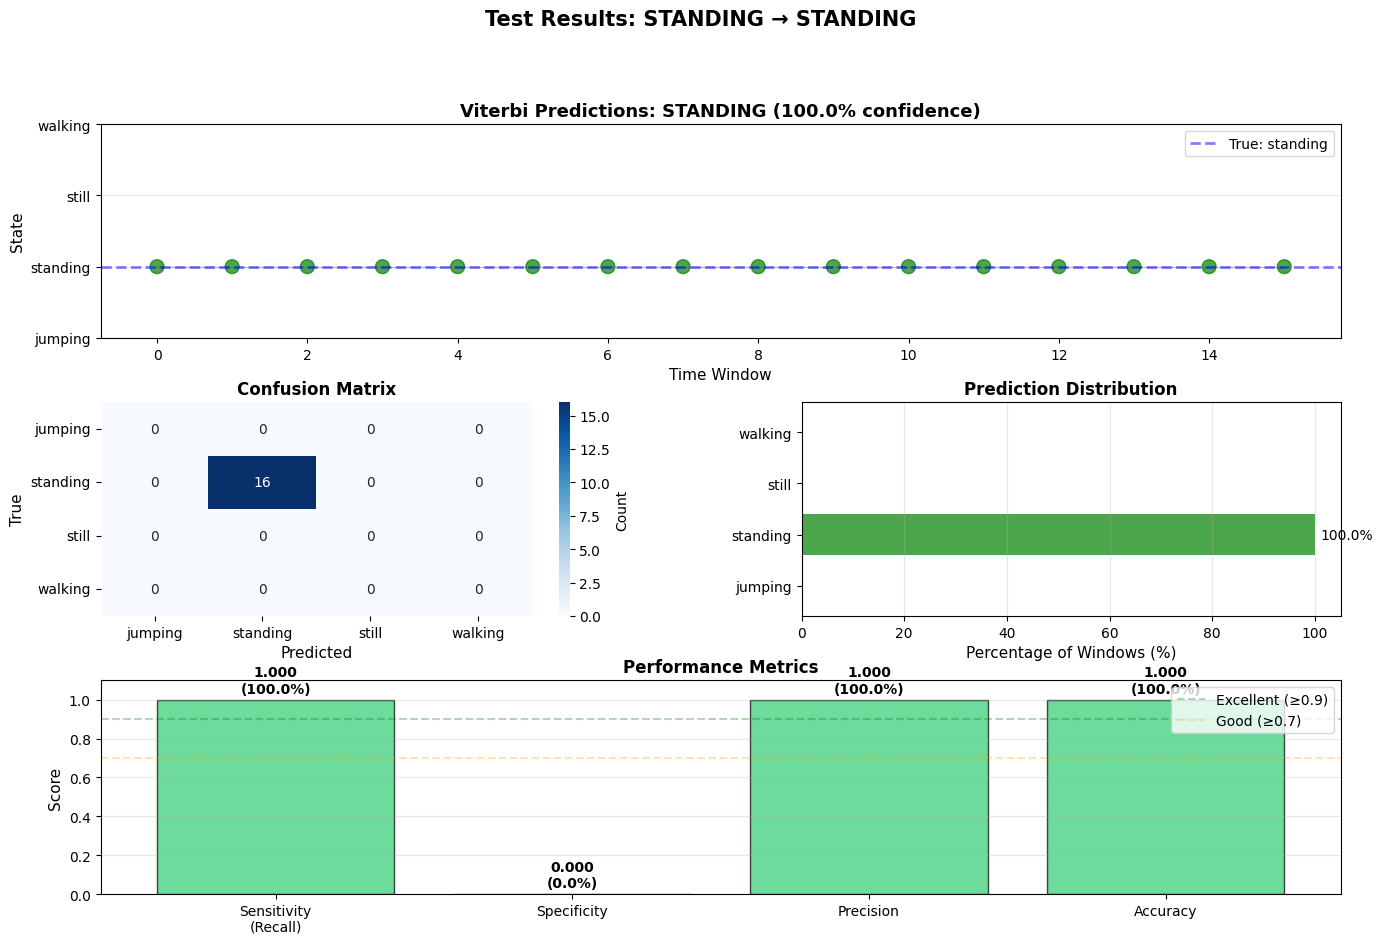


──────────────────────────────────────────────────────────────────────
Testing: STANDING
──────────────────────────────────────────────────────────────────────

LOADING TEST DATA
Duration: 17.95 seconds
Samples: 8973
Combined shape: (8973, 8)

PREDICTING ACTIVITY WITH METRICS
Created 16 windows
Extracting features...
Running Viterbi algorithm...

PREDICTION RESULTS
True Activity: STANDING
Predicted Activity: STANDING
Confidence: 100.0% (16/16 windows)
✓ CORRECT PREDICTION

PERFORMANCE METRICS
Sensitivity (Recall):    1.0000 (100.00%)
Specificity:             0.0000 (0.00%)
Precision:               1.0000 (100.00%)
Accuracy:                1.0000 (100.00%)

True Positives (TP):     16
False Positives (FP):    0
True Negatives (TN):     0
False Negatives (FN):    0

WINDOW-LEVEL BREAKDOWN
✓ standing  : ██████████████████████████████████████████████████  16 (100.0%)



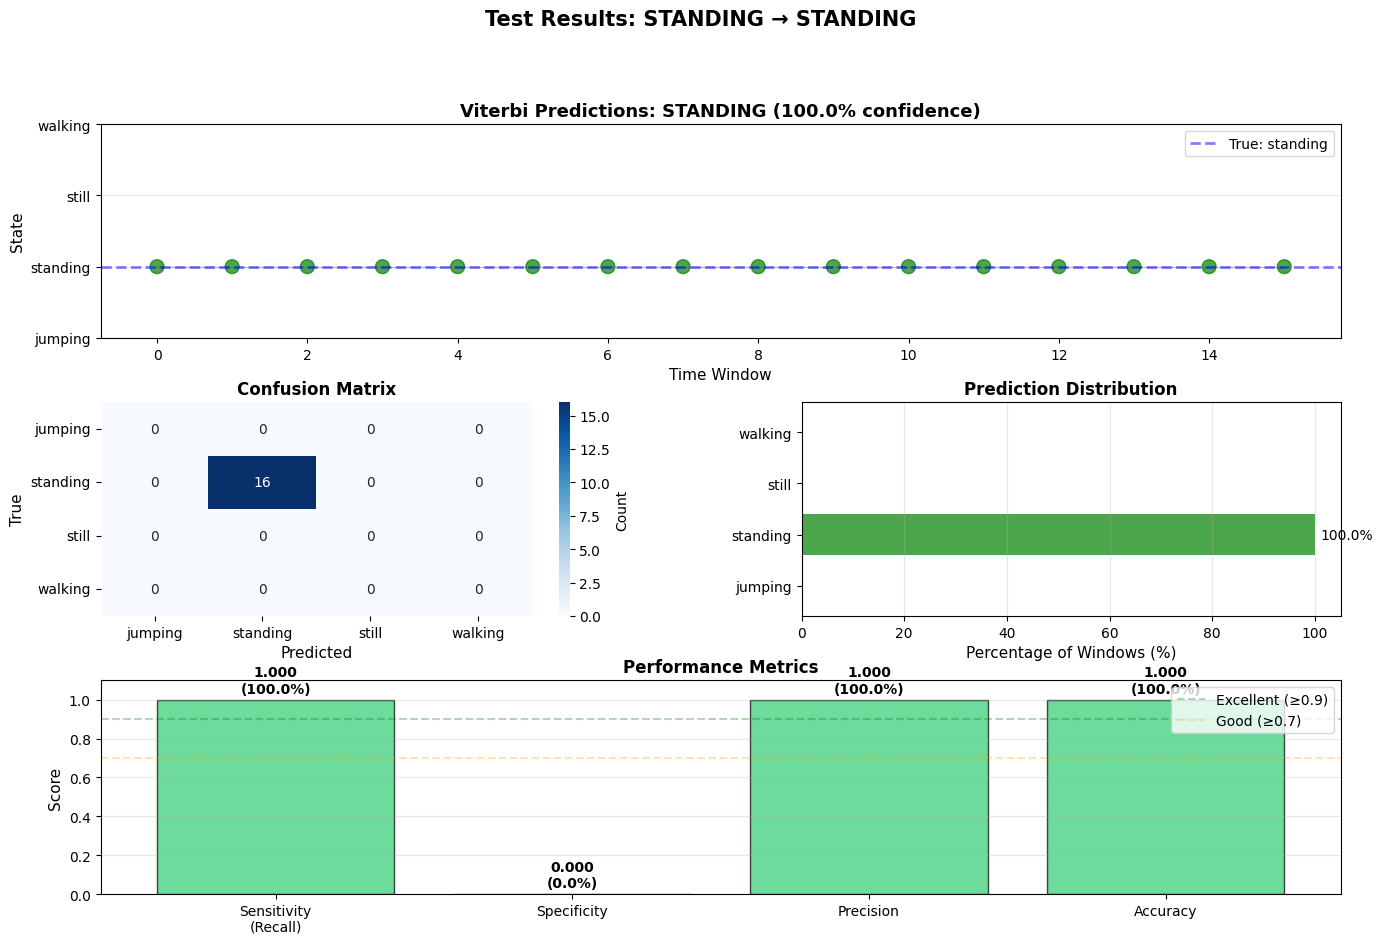


SUMMARY TABLE - ALL TEST ACTIVITIES
True Activity Predicted Correct Sensitivity Specificity Precision Accuracy Confidence  Windows
     standing  standing       ✓      1.0000      0.0000    1.0000   1.0000     100.0%       16

AVERAGE METRICS ACROSS ALL TESTS:
  Sensitivity: 1.0000 (100.00%)
  Specificity: 0.0000 (0.00%)
  Precision:   1.0000 (100.00%)
  Accuracy:    1.0000 (100.00%)


In [67]:

from sklearn.metrics import confusion_matrix, classification_report

def combine_and_prepare_test_data(accel_csv, gyro_csv, resample_rate=500):
    """Combine test accelerometer and gyroscope files"""
    print("\n" + "="*70)
    print("LOADING TEST DATA")
    print("="*70)

    accel_df = pd.read_csv(accel_csv)
    gyro_df = pd.read_csv(gyro_csv)

    accel_df.columns = accel_df.columns.str.lower().str.strip().str.replace(" ", "_").str.replace(r"[()]", "", regex=True)
    gyro_df.columns = gyro_df.columns.str.lower().str.strip().str.replace(" ", "_").str.replace(r"[()]", "", regex=True)

    accel_columns = [c for c in accel_df.columns if c != "time"]
    accel_df = accel_df.rename(columns={c: f"linear_{c}" for c in accel_columns})
    accel_df = accel_df.rename(columns={"time": "linear_time"})

    start_time = max(accel_df["linear_time"].min(), gyro_df["time"].min())
    end_time = min(accel_df["linear_time"].max(), gyro_df["time"].max())
    duration = end_time - start_time
    num_samples = int(duration * resample_rate)

    print(f"Duration: {duration:.2f} seconds")
    print(f"Samples: {num_samples}")

    common_time = np.linspace(start_time, end_time, num_samples)

    linear_cols = [c for c in accel_df.columns if c != "linear_time"]
    accel_interp = pd.DataFrame({
        col: np.interp(common_time, accel_df["linear_time"], accel_df[col])
        for col in linear_cols
    })
    accel_interp["linear_time"] = common_time

    gyro_cols = [c for c in gyro_df.columns if c != "time"]
    gyro_interp = pd.DataFrame({
        col: np.interp(common_time, gyro_df["time"], gyro_df[col])
        for col in gyro_cols
    })

    combined = pd.concat([accel_interp, gyro_interp], axis=1)

    print(f"Combined shape: {combined.shape}")
    print("="*70 + "\n")

    return combined


def predict_activity_with_metrics(hmm_model, test_df, extractor, true_activity):
    """
    Predict activity and calculate sensitivity/specificity metrics

    Args:
        hmm_model: Trained HMM model
        test_df: Test dataframe
        extractor: Feature extractor
        true_activity: Ground truth activity label (string)
    """
    print("="*70)
    print("PREDICTING ACTIVITY WITH METRICS")
    print("="*70)

    windows = []
    window_samples = int(extractor.window_size * extractor.sampling_rate)
    step_samples = int(window_samples * (1 - extractor.overlap))

    if len(test_df) < window_samples:
        print(f"Data too short! Need {window_samples} samples, have {len(test_df)}")
        return None

    for start in range(0, len(test_df) - window_samples + 1, step_samples):
        windows.append(test_df.iloc[start:start+window_samples])

    print(f"Created {len(windows)} windows")

    # Extract features
    print(f"Extracting features...")
    feature_list = []
    for window in windows:
        features = extractor.extract_window_features(window)
        feature_list.append(features)

    features_df = pd.DataFrame(feature_list)

    # Prepare and scale features
    X_test = features_df.values
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=1e10, neginf=-1e10)
    X_scaled = hmm_model.scaler.transform(X_test)

    # Predict using Viterbi
    print(f"Running Viterbi algorithm...")
    _, pred_sequence = hmm_model.model.decode(X_scaled, algorithm='viterbi')

    # Get true label index
    true_idx = hmm_model.state_to_idx[true_activity]
    y_true = np.full(len(pred_sequence), true_idx)  # All windows should be this activity

    # Calculate metrics
    n_states = len(hmm_model.state_names)
    conf_matrix = confusion_matrix(y_true, pred_sequence, labels=range(n_states))

    # For the TRUE activity class
    tp = conf_matrix[true_idx, true_idx]
    fp = conf_matrix[:, true_idx].sum() - tp
    fn = conf_matrix[true_idx, :].sum() - tp
    tn = conf_matrix.sum() - tp - fp - fn

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    accuracy = (tp + tn) / conf_matrix.sum() if conf_matrix.sum() > 0 else 0.0

    # Majority vote prediction
    counts = np.bincount(pred_sequence, minlength=n_states)
    majority_state = np.argmax(counts)
    predicted_activity = hmm_model.idx_to_state[majority_state]
    confidence = (counts[majority_state] / len(pred_sequence)) * 100

    # Print results
    print("\n" + "="*70)
    print("PREDICTION RESULTS")
    print("="*70)
    print(f"True Activity: {true_activity.upper()}")
    print(f"Predicted Activity: {predicted_activity.upper()}")
    print(f"Confidence: {confidence:.1f}% ({counts[majority_state]}/{len(pred_sequence)} windows)")

    if predicted_activity == true_activity:
        print("✓ CORRECT PREDICTION")
    else:
        print("✗ INCORRECT PREDICTION")

    print(f"\n{'='*70}")
    print("PERFORMANCE METRICS")
    print(f"{'='*70}")
    print(f"Sensitivity (Recall):    {sensitivity:.4f} ({sensitivity*100:.2f}%)")
    print(f"Specificity:             {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"Precision:               {precision:.4f} ({precision*100:.2f}%)")
    print(f"Accuracy:                {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"\nTrue Positives (TP):     {tp}")
    print(f"False Positives (FP):    {fp}")
    print(f"True Negatives (TN):     {tn}")
    print(f"False Negatives (FN):    {fn}")

    print(f"\n{'='*70}")
    print("WINDOW-LEVEL BREAKDOWN")
    print(f"{'='*70}")
    for state_idx, count in enumerate(counts):
        if count > 0:
            activity_name = hmm_model.idx_to_state[state_idx]
            percentage = (count / len(pred_sequence)) * 100
            bar = "█" * int(percentage / 2)
            marker = "✓" if activity_name == true_activity else "✗"
            print(f"{marker} {activity_name:10s}: {bar:50s} {count:3d} ({percentage:5.1f}%)")
    print(f"{'='*70}\n")

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    ax1 = fig.add_subplot(gs[0, :])
    time_windows = np.arange(len(pred_sequence))
    colors = ['green' if hmm_model.idx_to_state[p] == true_activity else 'red'
              for p in pred_sequence]
    ax1.scatter(time_windows, pred_sequence, c=colors, s=100, alpha=0.7)
    ax1.axhline(y=true_idx, color='blue', linestyle='--', linewidth=2,
                label=f'True: {true_activity}', alpha=0.5)
    ax1.plot(time_windows, pred_sequence, 'k-', linewidth=1, alpha=0.2)
    ax1.set_yticks(range(len(hmm_model.state_names)))
    ax1.set_yticklabels(hmm_model.state_names)
    ax1.set_xlabel('Time Window', fontsize=11)
    ax1.set_ylabel('State', fontsize=11)
    ax1.set_title(f'Viterbi Predictions: {predicted_activity.upper()} ({confidence:.1f}% confidence)',
                  fontsize=13, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3, axis='y')

    ax2 = fig.add_subplot(gs[1, 0])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=hmm_model.state_names,
                yticklabels=hmm_model.state_names,
                cbar_kws={'label': 'Count'}, ax=ax2)
    ax2.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Predicted', fontsize=11)
    ax2.set_ylabel('True', fontsize=11)

    ax3 = fig.add_subplot(gs[1, 1])
    percentages = (counts / len(pred_sequence)) * 100
    colors_bar = ['green' if hmm_model.idx_to_state[i] == true_activity else 'red'
                  for i in range(len(counts))]
    bars = ax3.barh(hmm_model.state_names, percentages, color=colors_bar, alpha=0.7)
    ax3.set_xlabel('Percentage of Windows (%)', fontsize=11)
    ax3.set_title('Prediction Distribution', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='x')
    for i, (bar, pct) in enumerate(zip(bars, percentages)):
        if pct > 0:
            ax3.text(pct + 1, i, f'{pct:.1f}%', va='center', fontsize=10)

    ax4 = fig.add_subplot(gs[2, :])
    metrics = ['Sensitivity\n(Recall)', 'Specificity', 'Precision', 'Accuracy']
    values = [sensitivity, specificity, precision, accuracy]
    colors_metrics = ['#2ecc71' if v >= 0.9 else '#f39c12' if v >= 0.7 else '#e74c3c'
                      for v in values]
    bars = ax4.bar(metrics, values, color=colors_metrics, alpha=0.7, edgecolor='black')
    ax4.set_ylim(0, 1.1)
    ax4.set_ylabel('Score', fontsize=11)
    ax4.set_title('Performance Metrics', fontsize=12, fontweight='bold')
    ax4.axhline(y=0.9, color='green', linestyle='--', alpha=0.3, label='Excellent (≥0.9)')
    ax4.axhline(y=0.7, color='orange', linestyle='--', alpha=0.3, label='Good (≥0.7)')
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.legend(loc='upper right')

    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}\n({val*100:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.suptitle(f'Test Results: {true_activity.upper()} → {predicted_activity.upper()}',
                 fontsize=15, fontweight='bold', y=0.995)
    plt.show()

    return {
        'predicted_activity': predicted_activity,
        'true_activity': true_activity,
        'confidence': confidence,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'pred_sequence': pred_sequence,
        'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
        'n_windows': len(pred_sequence)
    }


def test_multiple_activities(hmm_model, extractor, test_files):

    all_results = []


    for accel_file, gyro_file, true_activity in test_files:
        print(f"\n{'─'*70}")
        print(f"Testing: {true_activity.upper()}")
        print(f"{'─'*70}")

        test_df = combine_and_prepare_test_data(accel_file, gyro_file, resample_rate=500)
        results = predict_activity_with_metrics(hmm_model, test_df, extractor, true_activity)

        if results:
            all_results.append(results)

    if all_results:
        print("\n" + "="*70)
        print("SUMMARY TABLE - ALL TEST ACTIVITIES")
        print("="*70)

        summary_df = pd.DataFrame([{
            'True Activity': r['true_activity'],
            'Predicted': r['predicted_activity'],
            'Correct': '✓' if r['predicted_activity'] == r['true_activity'] else '✗',
            'Sensitivity': f"{r['sensitivity']:.4f}",
            'Specificity': f"{r['specificity']:.4f}",
            'Precision': f"{r['precision']:.4f}",
            'Accuracy': f"{r['accuracy']:.4f}",
            'Confidence': f"{r['confidence']:.1f}%",
            'Windows': r['n_windows']
        } for r in all_results])

        print(summary_df.to_string(index=False))
        print("="*70 + "\n")

        avg_sensitivity = np.mean([r['sensitivity'] for r in all_results])
        avg_specificity = np.mean([r['specificity'] for r in all_results])
        avg_precision = np.mean([r['precision'] for r in all_results])
        avg_accuracy = np.mean([r['accuracy'] for r in all_results])

        print("AVERAGE METRICS ACROSS ALL TESTS:")
        print(f"  Sensitivity: {avg_sensitivity:.4f} ({avg_sensitivity*100:.2f}%)")
        print(f"  Specificity: {avg_specificity:.4f} ({avg_specificity*100:.2f}%)")
        print(f"  Precision:   {avg_precision:.4f} ({avg_precision*100:.2f}%)")
        print(f"  Accuracy:    {avg_accuracy:.4f} ({avg_accuracy*100:.2f}%)")

        return summary_df, all_results

    return None, []

print("\n" + "="*70)
print("SINGLE FILE TEST")
print("="*70)

accel_test = "/content/linear test standing .csv"
gyro_test = "/content/test standing .csv"
true_activity = "standing"

test_df = combine_and_prepare_test_data(accel_test, gyro_test, resample_rate=500)
results = predict_activity_with_metrics(hmm_model, test_df, extractor, true_activity)


test_files = [
    ("/content/linear test standing .csv", "/content/test standing .csv", "standing"),
]

summary_table, all_test_results = test_multiple_activities(hmm_model, extractor, test_files)